In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "../src"))

In [2]:
import logging
import jax
import jax.numpy as np
import numpy as onp
import skbio.stats.composition as cmp
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import statsmodels.api as sm
from datetime import datetime

from simulate_data_fct import sim_IV_lognormal_linear
from plot_fct import update_layout, img_path, update_layout_px, colours, plot_ilr_X_vs_Y
from run_methods_all import run_methods_confidence_interval
from plot_fct import plot_mse_results, plot_beta_results

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# set up logging file
logging.getLogger().setLevel(logging.INFO)

In [5]:
key = jax.random.PRNGKey(191)

# Linear Setup

## Data Generation

In [6]:
n = 500
p = 30
num_star = 250
instrument_strength = "unknown_inst20_run20"
savepath = os.path.join(img_path, "HighDimLogcontrast")

V = cmp._gram_schmidt_basis(p)
num_inst=20
c_X = 2  # dispersion parameter

# instrument strength
alpha0 =np.hstack([np.array([1, 1, 2, 1, 4, 4, 2, 1, 4, 4, 2, 1]), jax.random.choice(key, np.array([1, 2, 2]), (p-8,))])
alphaT = jax.random.choice(key, np.array([0, 0, 0, 10]), (num_inst, p))
# confounder
mu_c = np.hstack([np.array([0.2, 0.3, 0.2, 0.1]), jax.random.uniform(key, (p-4, ), minval=0.01, maxval=0.05)])
mu_c = mu_c / mu_c.sum()  # has to be a compositional vector
ps = np.hstack([np.zeros((int(p/2),)), 0.8*np.ones((p - int(p/2),))])   # prob of zero inflation

# relationship between X and Y
beta0 = 1
betaT = np.hstack([ np.array([-5, -5, -5, -5]), np.array([5, 5, 5, 5]),  
                   np.zeros((p-8))])  # beta is chosen to sum up to one
# confounder influence to Y
c_Y = np.hstack([np.array([20, 20, 0, 0]), np.array([-5, -5, -5, -5, -5, -5, -5, -5]), 
                 np.zeros((p-12))])  # confounder is a composition as well.

In [7]:
confounder, Z_sim, X_sim, Y_sim, X_star, Y_star = sim_IV_lognormal_linear(
            key,
            n=n,
            p=p,
            num_inst=num_inst,
            mu_c=mu_c,
            c_X=c_X,
            alpha0=alpha0,
            alphaT=alphaT,
            c_Y=c_Y,
            beta0=beta0,
            betaT=betaT,
            num_star=500,
ps=ps)
X_sim_ilr = cmp.ilr(X_sim)
X_star_ilr = cmp.ilr(X_star)

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/skbio/stats/composition.py:464: RuntimeWarning: divide by zero encountered in log
  lmat = np.log(mat)
/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/skbio/stats/composition.py:466: RuntimeWarning: invalid value encountered in subtract
  return (lmat - gm).squeeze()


## Data Visualization

In [8]:
# Compute F-Statistics 
ZZ_sim = onp.array(sm.add_constant(Z_sim))
alphahat = np.linalg.inv(ZZ_sim.T@ZZ_sim)@ZZ_sim.T@X_sim_ilr
MSM = np.sum(((ZZ_sim@alphahat - np.mean(X_sim_ilr, axis=0))**2), axis=0)/(num_inst)
MSE = np.sum(((ZZ_sim@alphahat - X_sim_ilr)**2), axis=0)/(n-num_inst)
F = MSM / MSE
F

DeviceArray([3.9811573 , 4.0325174 , 0.6969691 , 1.1109637 , 2.0592277 ,
             1.1395363 , 2.1256394 , 2.472928  , 2.1710258 , 1.5875375 ,
             3.901856  , 6.61777   , 1.3800604 , 7.6650057 , 0.86743903,
             1.1249284 , 1.7043664 , 0.6813747 , 0.97126293, 1.208663  ,
             0.72704536, 1.1076996 , 0.5828584 , 1.1135736 , 1.389815  ,
             0.9585846 , 0.890294  , 0.7332782 , 0.7309371 ],            dtype=float32)

In [76]:
cut_off = 6
X_plot = np.hstack([X_sim[:, :cut_off], X_sim[:, cut_off:].sum(axis=1).T[..., np.newaxis]])
fig = px.bar(pd.DataFrame(X_plot[:100, :], columns=["Microbe "+str(i) for i in range(X_plot.shape[1]-1)] + ["Other"]))
fig = update_layout_px(fig)
fig.update_xaxes(title="Sample number")
fig.update_yaxes(title="Percentage of microbiota in sample")
fig.write_image(os.path.join(savepath,
                             "Barplot_Sample_" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))
fig.show()

In [77]:
X_sim.shape

(500, 30)

In [72]:
fig = plot_ilr_X_vs_Y(X_sim_ilr, X_star_ilr, Y_sim, Y_star)

fig.update_layout(xaxis3=dict(showline=True, linewidth=2, linecolor="black"))
fig.update_layout(yaxis3=dict(showline=True, linewidth=2, linecolor="black"))
fig.update_layout(xaxis4=dict(showline=True, linewidth=2, linecolor="black"))
fig.update_layout(yaxis4=dict(showline=True, linewidth=2, linecolor="black"))
fig.update_layout(xaxis5=dict(showline=True, linewidth=2, linecolor="black"))
fig.update_layout(yaxis5=dict(showline=True, linewidth=2, linecolor="black"))
fig.update_layout(width=2000, height=500)
fig.write_image(os.path.join(savepath,
                             "Data_vs_trueeffect_" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))


fig.show()

# Diversity Approach

In [10]:
from plot_fct import plot_diversity_methods
from helper_fct import diversity
from run_methods_all import run_diversity_estimation_methods
div_shannon = diversity(X_sim, "shannon")
div_simpson = diversity(X_sim, "simpson")

In [11]:
# Shannon Estimation
x, y, ytrue, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results = run_diversity_estimation_methods(
    Z_sim, div_shannon, Y_sim, Ytrue=Y_star, methods=["OLS", "2SLS", "KIV"])

fig = plot_diversity_methods(x, y, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results, ytrue)
fig.write_image(os.path.join(savepath,
                             "ShannonDiversity_" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))

fig.show()

INFO:absl:Setup matrices...


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9329
Date:                 Fr, 11 Jun 2021   Prob (F-statistic):              0.545
Time:                        17:13:46   Log-Likelihood:                -699.92
No. Observations:                 500   AIC:                             1442.
Df Residuals:                     479   BIC:                             1530.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6007      0.436     -1.377      0.1

INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [4.56162678]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [6.65014204]...
INFO:absl:Predict treatment effect...


In [12]:
# Simpson Estimation
x, y, ytrue, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results = run_diversity_estimation_methods(
    Z_sim, div_simpson, Y_sim, Ytrue=Y_star, methods=["OLS", "2SLS", "KIV"])

plot_diversity_methods(x, y, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results, ytrue)
fig.write_image(os.path.join(savepath,
                             "SimpsonDiversity_" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))

fig.show()

INFO:absl:Setup matrices...
INFO:absl:Optimize lambda...


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.039
Date:                 Fr, 11 Jun 2021   Prob (F-statistic):              0.414
Time:                        17:13:49   Log-Likelihood:                -698.86
No. Observations:                 500   AIC:                             1440.
Df Residuals:                     479   BIC:                             1528.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6041      0.435     -1.387      0.1

INFO:absl:Optimal lambda [4.52593536]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [3.82877099]...
INFO:absl:Predict treatment effect...


# Confidence Intervals for higher dimensional methods

In [13]:
from run_methods_all import run_methods_all

**************************************************************************************************
*****************************************We are at 0 of 20***********************************************
**************************************************************************************************
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY Second Stage - ILR Regression >>>>>>>>>>>>>>>>>>>>>>>>>>>
True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-2.49 -0.58  2.55 -2.95 -3.36 -0.12 -3.05  2.98  2.7   1.11  1.56  2.53
  7.33  0.21  2.68  4.59  2.5   2.41  2.29  1.67 -0.46  2.61  1.49  1.
  2.    4.8   1.32  1.79  7.8 ]
Estimated Beta: [ 0.43  3.96  2.9  -0.52  5.    6.03  3.09  6.25  0.24  0.2   1.6   1.03
 -0.12 -5.29  1.56 -1.01 -3.15 -1.26 -1.32 -1.31 -0.8   1.31 -1.81 -0.78
 -0.35 -1.4  -4.34 

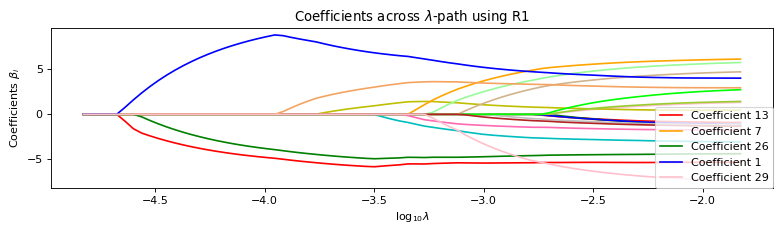

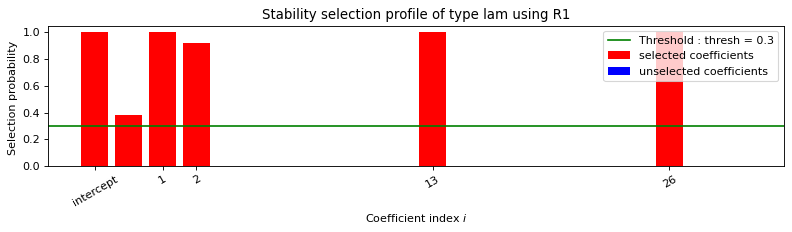

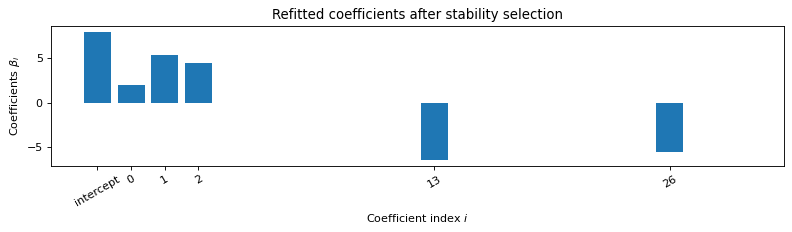


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.018s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.091s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.03  5.37  4.47  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.36  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.51  0.    0.    0.  ]
Error: 4158.42

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


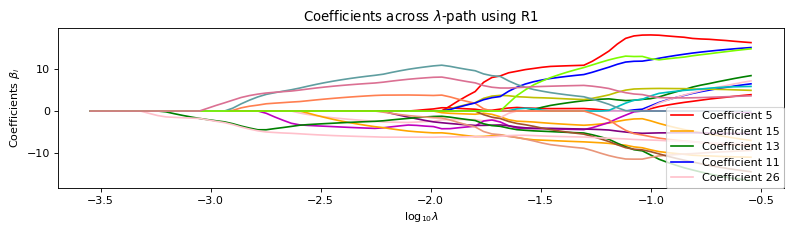

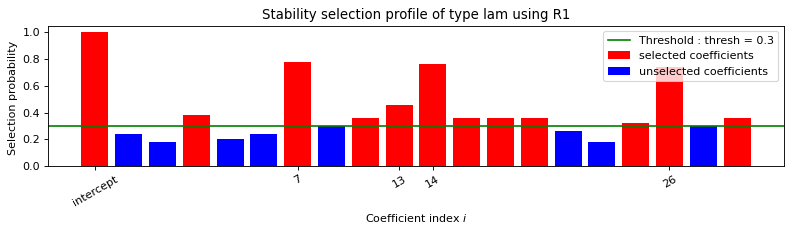

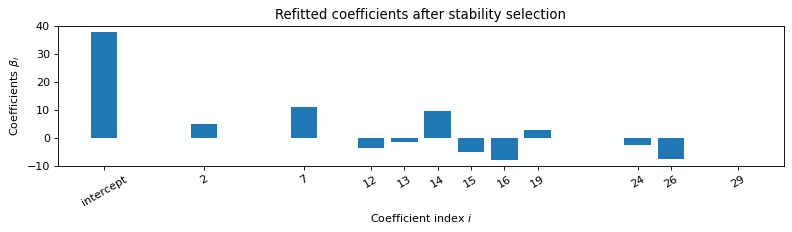


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.018s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    7    12    13    14    15    16    19    24    26    29    
   Running time :  0.215s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    0.    4.91  0.    0.    0.    0.   11.12  0.    0.    0.    0.
 -3.48 -1.62  9.51 -5.18 -7.77  0.    0.    2.94  0.    0.    0.    0.
 -2.53  0.   -7.72  0.    0.   -0.19]
Error: 3045.56

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


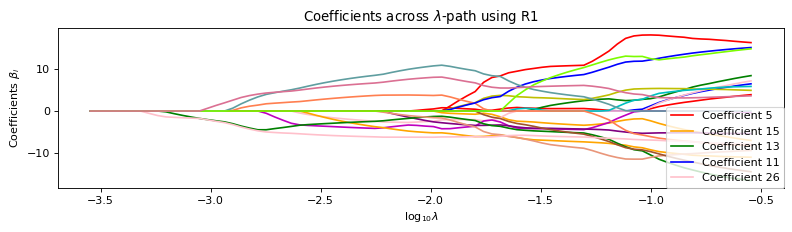

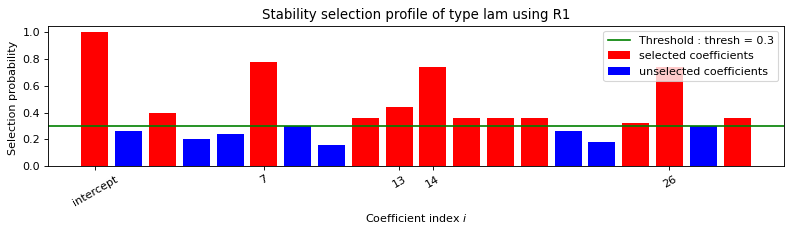

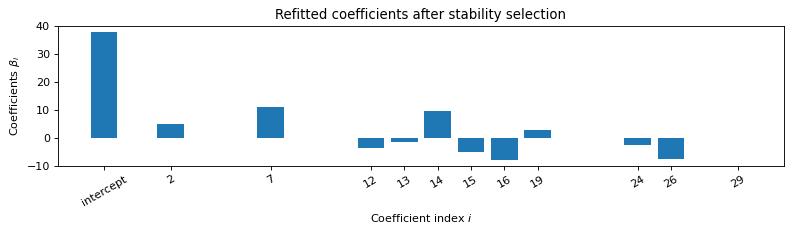


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.018s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    7    12    13    14    15    16    19    24    26    29    
   Running time :  0.207s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.   -4.01  1.42  1.1   0.9   0.76 -9.74  1.89  1.69  1.53  1.39  4.62
  2.49 -8.43  6.33  8.46  0.43  0.41 -2.48  0.51  0.49  0.46  0.44  2.91
  0.31  7.87  0.01  0.01  0.19]
Error: 3045.56

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 1055.5

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 4143.28

----------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -29.418
Model:                         IV2SLS   Adj. R-squared:                -31.295
Method:                     Two Stage   F-statistic:                 0.0006701
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        17:17:28                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.1861   1.75e+08   2.07e-07      1.0

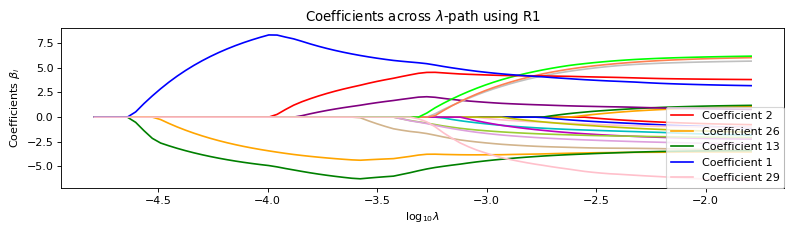

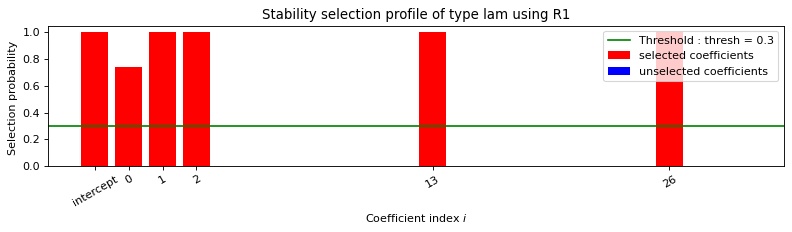

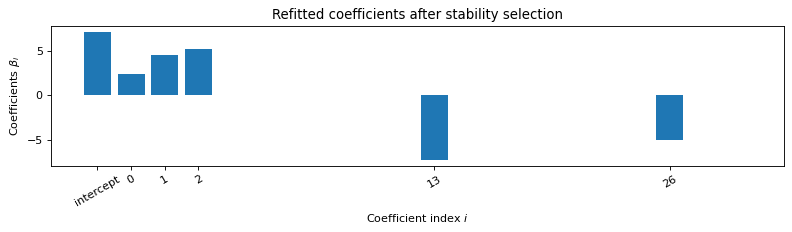


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.055s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.144s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.44  4.55  5.19  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.21  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.98  0.    0.    0.  ]
Error: 3818.08

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


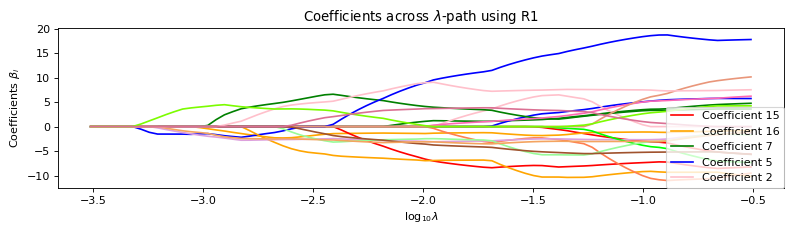

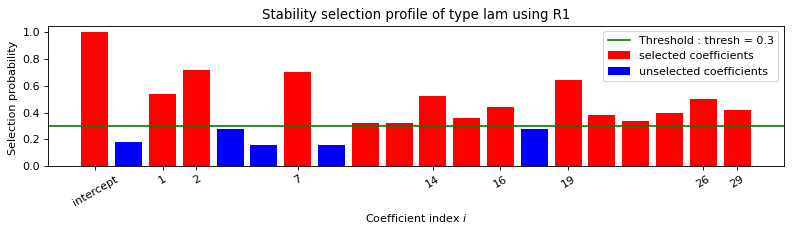

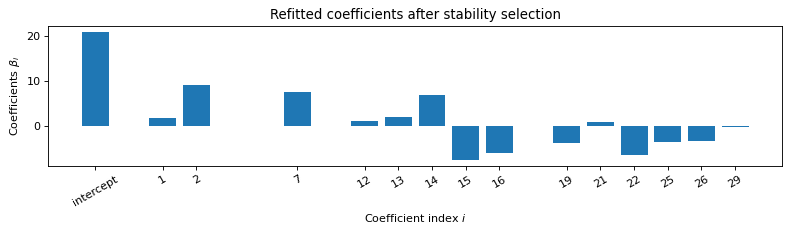


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.015s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    15    16    19    21    22    25    26    29    
   Running time :  0.235s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    1.92  9.19  0.    0.    0.    0.    7.65  0.    0.    0.    0.
  1.26  2.15  6.97 -7.34 -5.9   0.    0.   -3.69  0.    1.01 -6.39  0.
  0.   -3.53 -3.15  0.    0.   -0.15]
Error: 3644.52

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


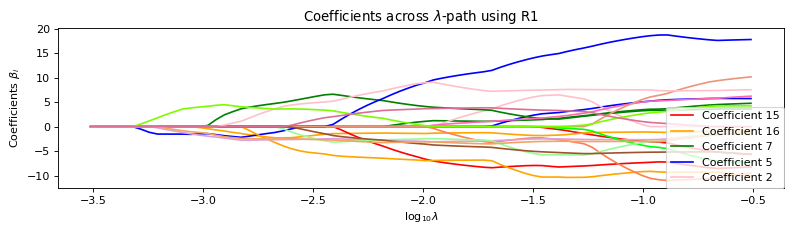

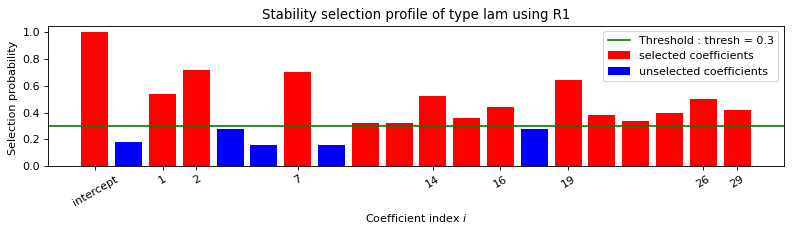

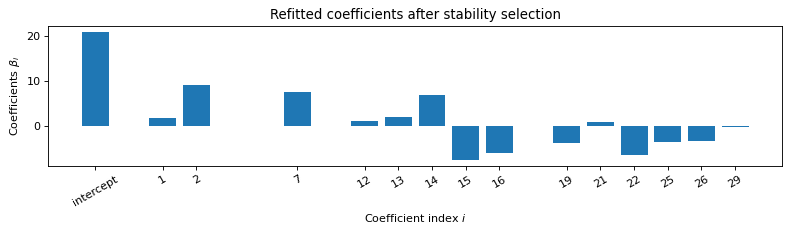


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    15    16    19    21    22    25    26    29    
   Running time :  0.154s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-1.36 -6.72  3.21  2.48  2.03  1.71 -5.67  2.21  1.98  1.79  1.63  0.3
 -0.58 -5.2   8.98  7.04  0.91  0.86  4.42  0.6  -0.42  6.83  0.29  0.28
  3.73  3.21  0.01  0.01  0.15]
Error: 3644.52

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 1659.58

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 383

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -6.993
Model:                         IV2SLS   Adj. R-squared:                 -7.486
Method:                     Two Stage   F-statistic:                 -0.005918
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:18:42                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        117.6438   3.47e+07   3.39e-06      1.0

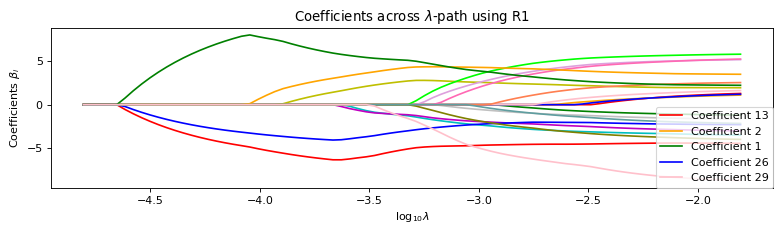

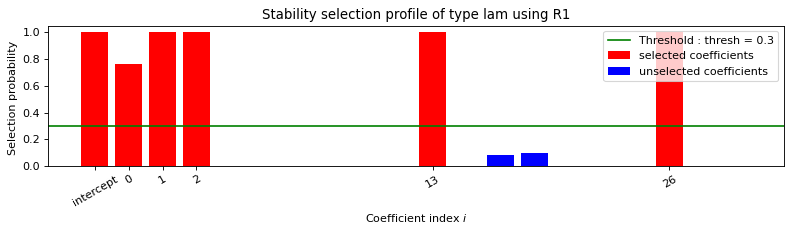

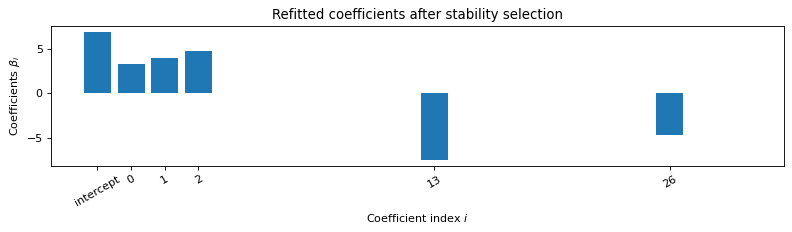


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.018s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.082s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.37  4.    4.78  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.47  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.68  0.    0.    0.  ]
Error: 3553.43

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


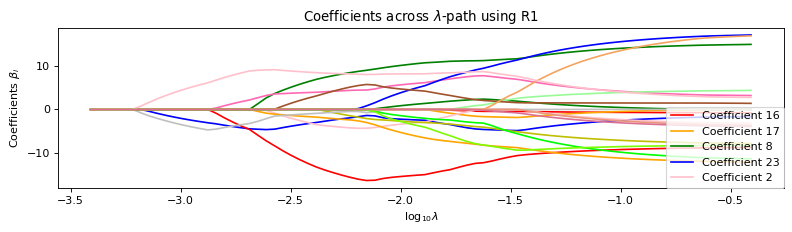

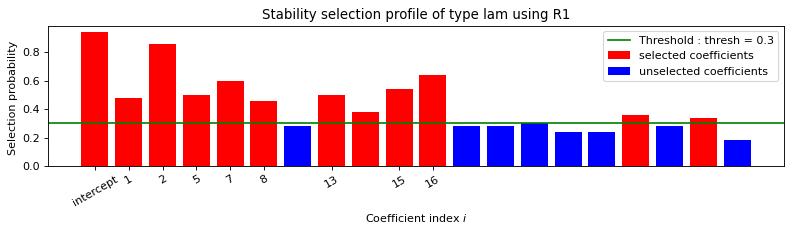

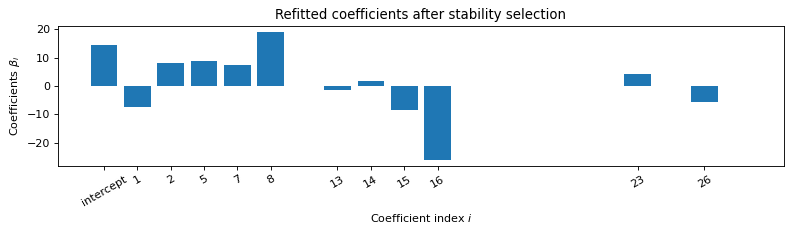


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    7    8    13    14    15    16    23    26    
   Running time :  0.267s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -7.5    8.14   0.     0.     8.76   0.     7.4   18.98   0.
   0.     0.     0.    -1.3    1.59  -8.46 -26.02   0.     0.     0.
   0.     0.     0.     4.17   0.     0.    -5.75   0.     0.     0.  ]
Error: 3160.79

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


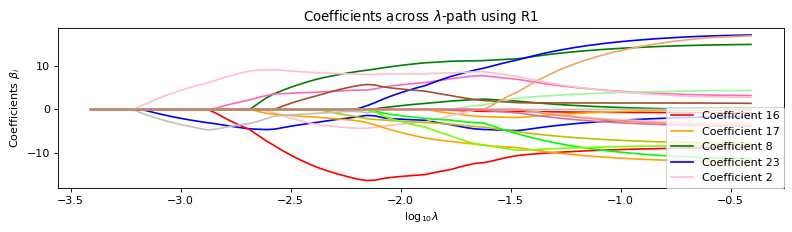

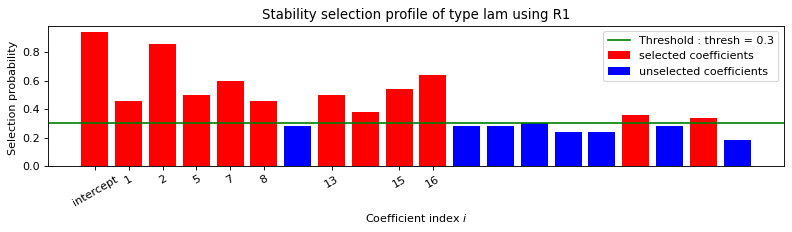

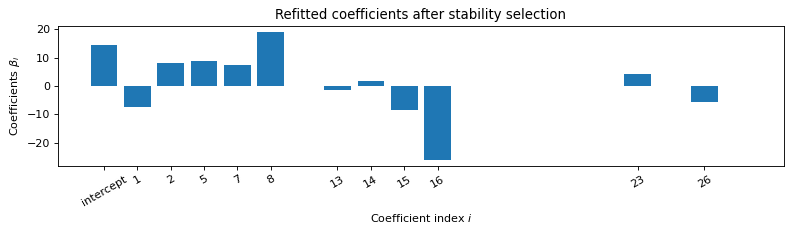


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.016s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    7    8    13    14    15    16    23    26    
   Running time :  0.312s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  5.3   -9.7    0.18   0.14  -7.88   1.45  -5.66 -15.92   3.77   3.41
   3.11   2.86   3.91   0.85  10.52  26.92   0.09   0.09   0.08   0.08
   0.07   0.07  -4.02   0.23   0.23   5.86   0.     0.     0.  ]
Error: 3160.79

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 1905.8

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -1.769
Model:                         IV2SLS   Adj. R-squared:                 -1.940
Method:                     Two Stage   F-statistic:                  0.006662
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:22:22                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0514        nan        nan        n

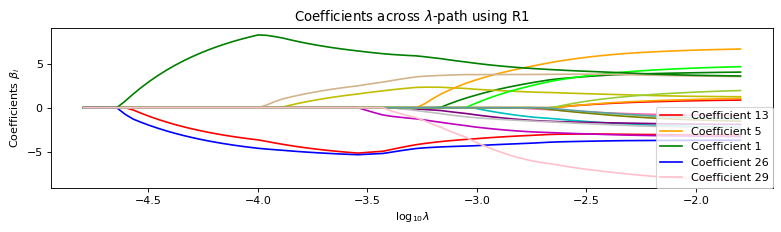

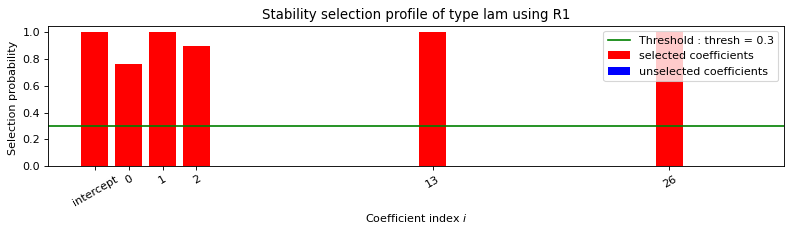

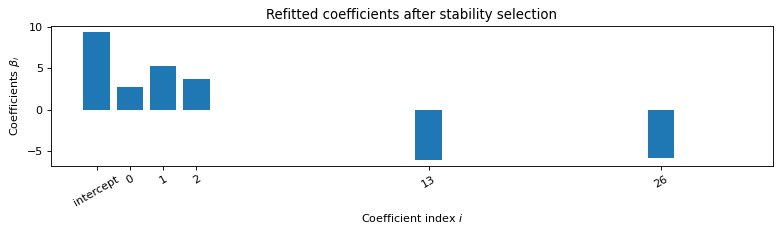


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.116s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.8   5.25  3.73  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.78  0.    0.    0.  ]
Error: 3637.46

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


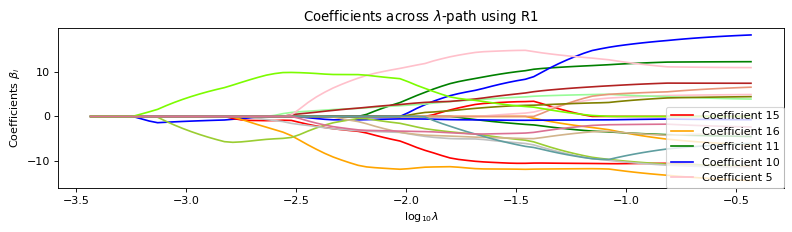

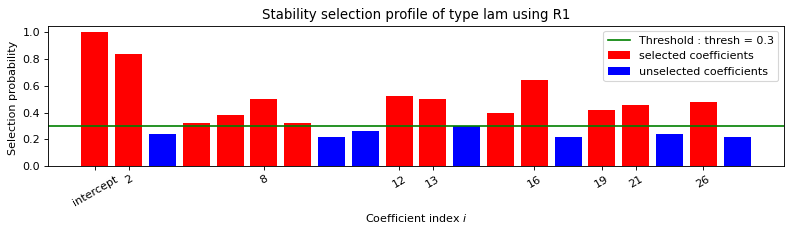

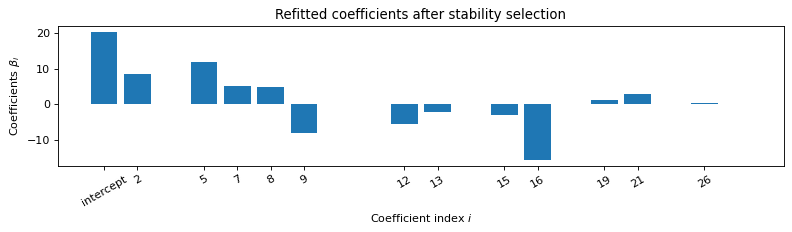


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.013s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    7    8    9    12    13    15    16    19    21    26    
   Running time :  0.232s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     0.     8.52   0.     0.    11.92   0.     5.21   4.75  -8.24
   0.     0.    -5.62  -2.18   0.    -3.04 -15.66   0.     0.     1.31
   0.     2.83   0.     0.     0.     0.     0.2    0.     0.     0.  ]
Error: 2994.46

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


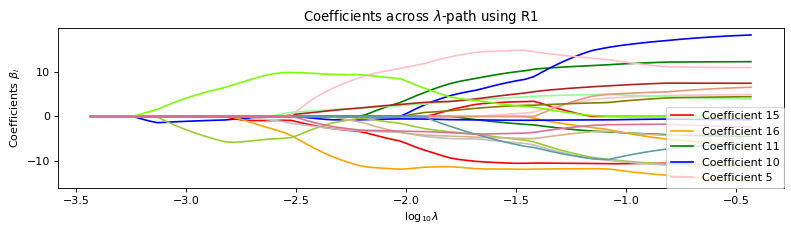

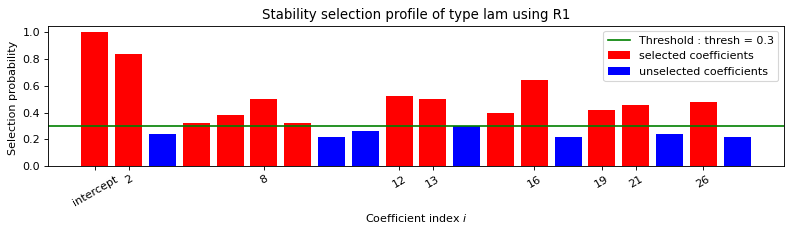

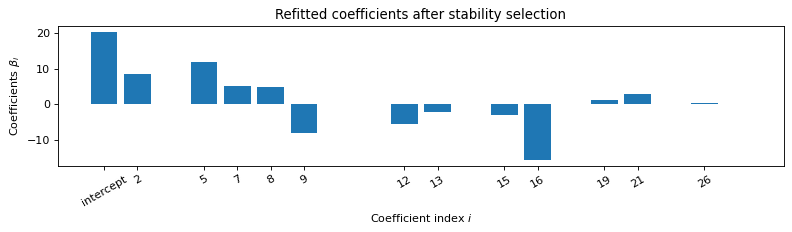


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    7    8    9    12    13    15    16    19    21    26    
   Running time :  0.207s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.000e+00 -6.960e+00  2.460e+00  1.910e+00 -9.320e+00  3.150e+00
 -2.140e+00 -1.460e+00  1.102e+01  2.110e+00  1.930e+00  7.170e+00
  3.330e+00  9.900e-01  3.870e+00  1.588e+01 -2.500e-01 -2.300e-01
 -1.500e+00 -1.500e-01 -2.910e+00 -1.000e-02 -1.000e-02 -1.000e-02
 -1.000e-02 -2.000e-01  0.000e+00  0.000e+00  0.000e+00]
Error: 2994.46

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 788.05

------------------------------------------------------------------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -11.354
Model:                         IV2SLS   Adj. R-squared:                -12.116
Method:                     Two Stage   F-statistic:                   0.04976
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:25:56                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.5282    2.5e+08   -6.6e-08      1.0

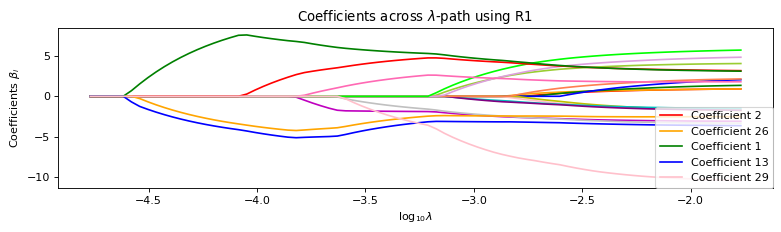

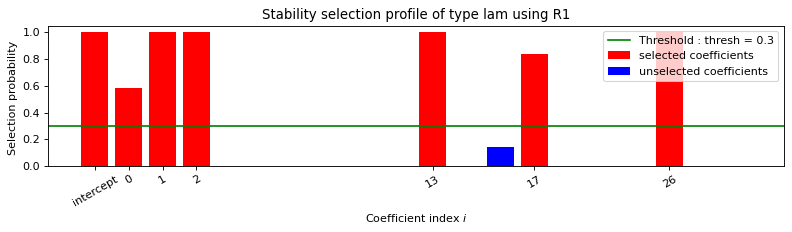

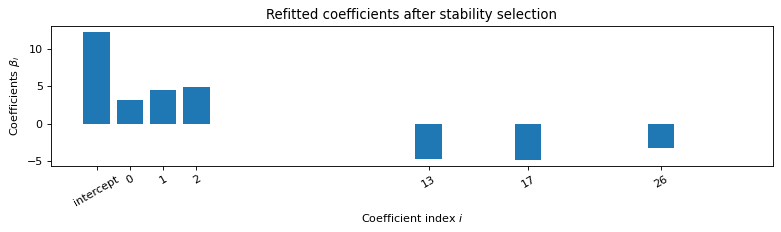


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    17    26    
   Running time :  0.091s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.21  4.56  4.94  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -4.64  0.    0.    0.   -4.78  0.    0.    0.    0.    0.    0.
  0.    0.   -3.28  0.    0.    0.  ]
Error: 3495.14

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


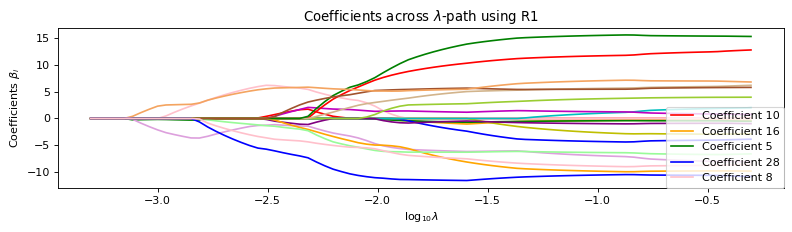

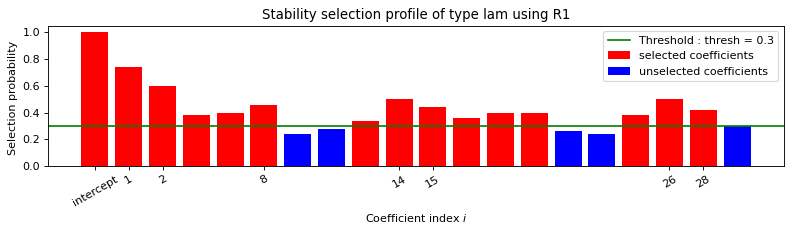

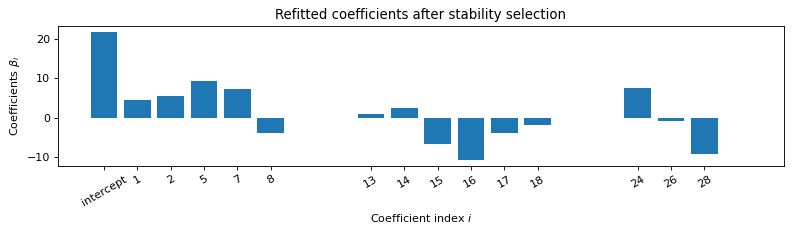


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    7    8    13    14    15    16    17    18    24    26    28    
   Running time :  0.218s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     4.47   5.47   0.     0.     9.43   0.     7.36  -3.82   0.
   0.     0.     0.     0.8    2.41  -6.7  -10.72  -3.92  -1.98   0.
   0.     0.     0.     0.     7.5    0.    -0.92   0.    -9.37   0.  ]
Error: 3385.23

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


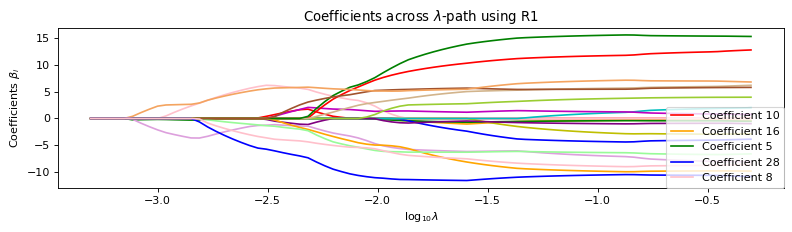

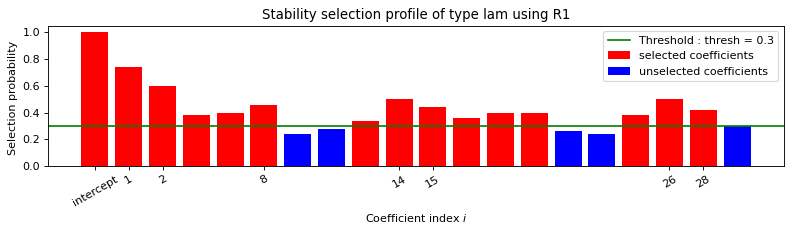

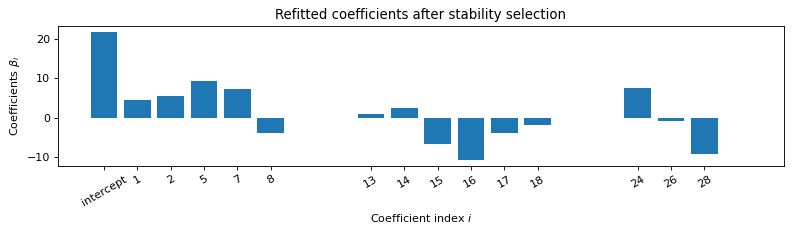


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    7    8    13    14    15    16    17    18    24    26    28    
   Running time :  0.218s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-3.16 -2.64  2.87  2.22 -6.79  2.99 -4.3   6.75  2.41  2.18  1.99  1.83
  0.93 -0.69  8.17 11.57  4.31  2.18  0.14  0.14  0.13  0.12  0.12 -7.23
  0.4   1.29  0.34  9.54  0.  ]
Error: 3385.23

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 574.4

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3498.6

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -19.290
Model:                         IV2SLS   Adj. R-squared:                -20.542
Method:                     Two Stage   F-statistic:                -6.165e-06
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:28:53                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -45.8006   1.29e+09  -3.54e-08      1.0

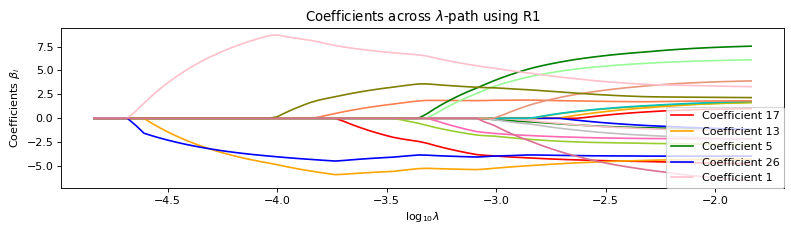

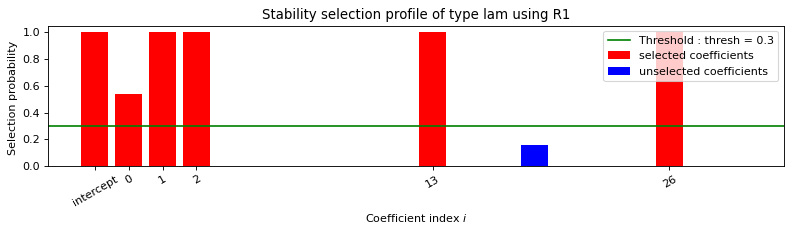

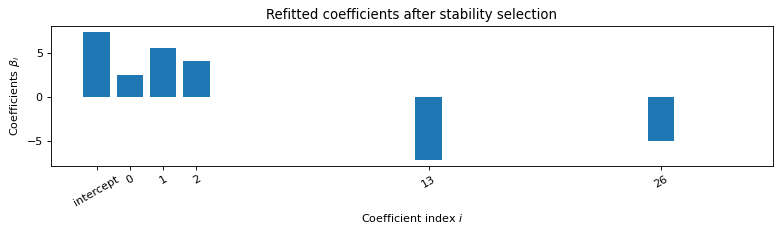


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.111s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.52  5.58  4.14  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.18  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.06  0.    0.    0.  ]
Error: 3448.41

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


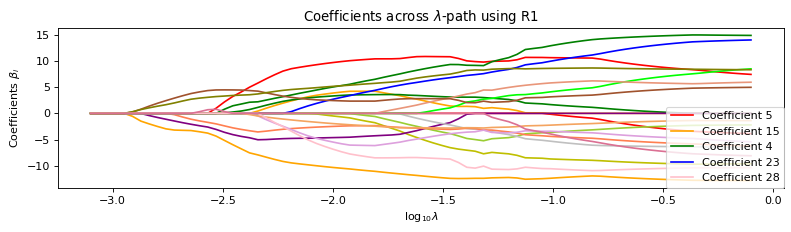

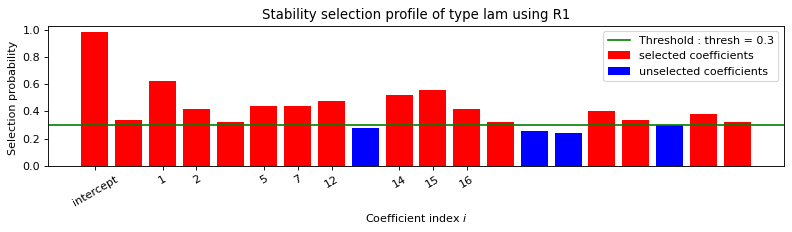

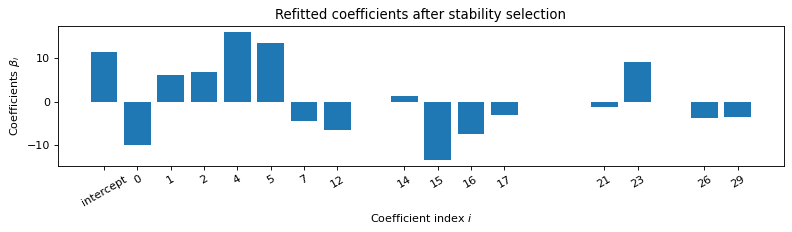


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    4    5    7    12    14    15    16    17    21    23    26    29    
   Running time :  0.212s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -9.93   6.19   6.92   0.    16.06  13.46   0.    -4.39   0.     0.
   0.     0.    -6.59   0.     1.22 -13.34  -7.37  -2.98   0.     0.
   0.    -1.24   0.     9.23   0.     0.    -3.66   0.     0.    -3.6 ]
Error: 2243.15

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


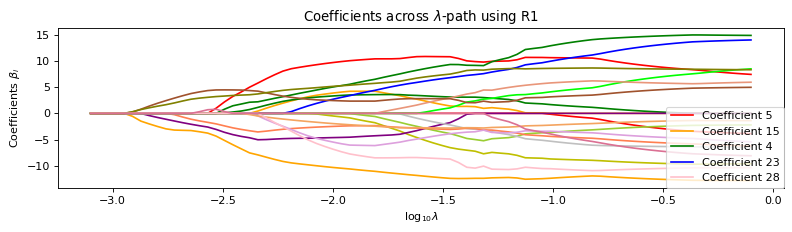

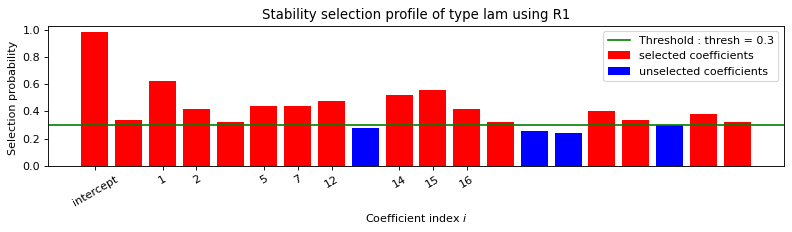

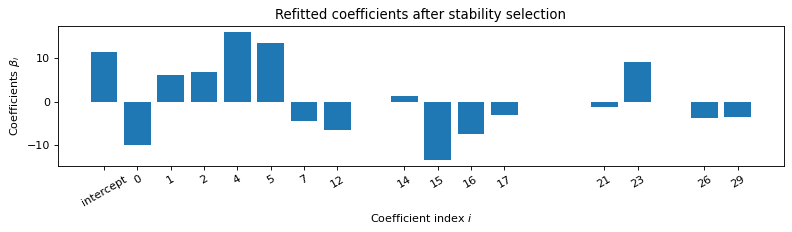


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.012s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    4    5    7    12    14    15    16    17    21    23    26    29    
   Running time :  0.262s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-11.4   -7.18   0.92 -13.66  -8.78   5.05   8.47   3.34   2.98   2.7
   2.46   8.6    1.61   0.32  14.4    7.73   3.02  -0.04  -0.04  -0.04
   1.17  -0.09  -9.12   0.3    0.28   3.86   0.13   0.13   3.66]
Error: 2243.16

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 1078.2

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -0.169
Model:                         IV2SLS   Adj. R-squared:                 -0.241
Method:                     Two Stage   F-statistic:                 2.136e-15
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:31:41                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2324   1.69e+09  -5.47e-09      1.0

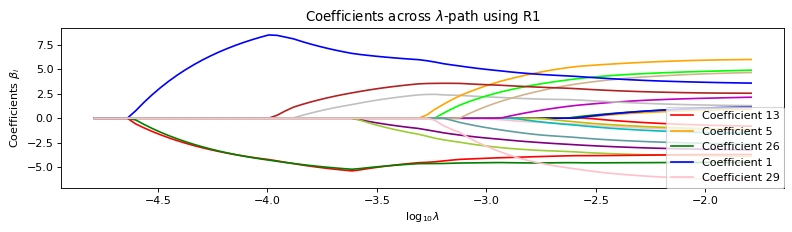

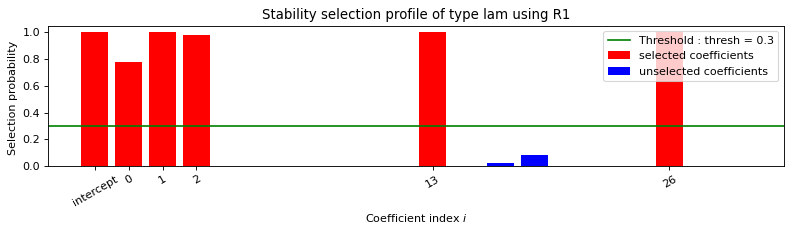

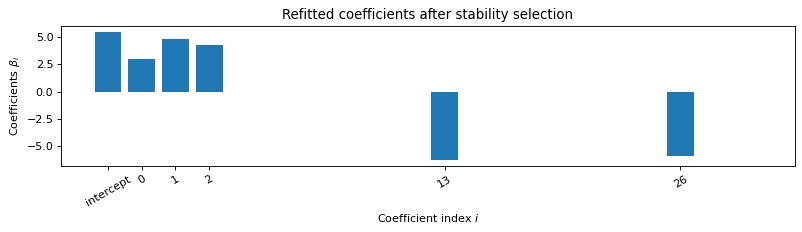


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.105s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.    4.88  4.31  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.27  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.92  0.    0.    0.  ]
Error: 3640.3

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


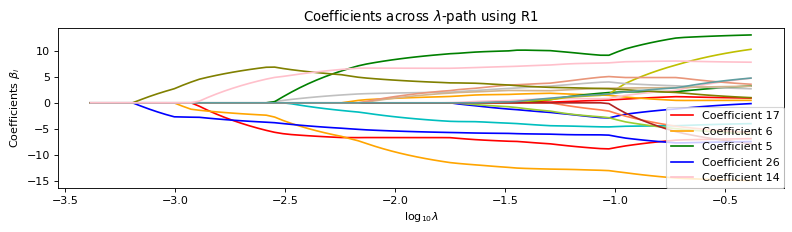

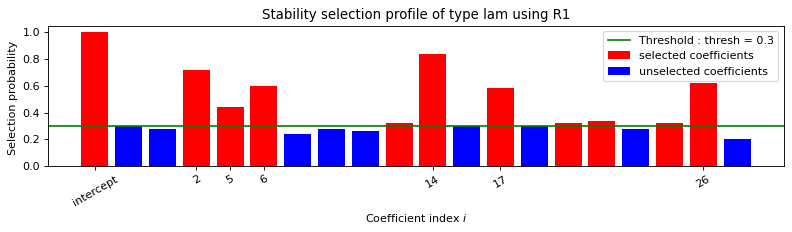

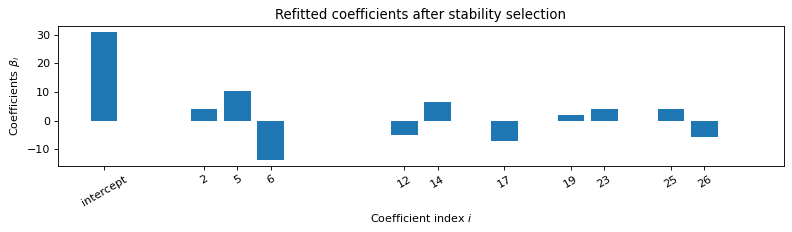


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    6    12    14    17    19    23    25    26    
   Running time :  0.175s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     0.     4.05   0.     0.    10.53 -13.6    0.     0.     0.
   0.     0.    -4.87   0.     6.55   0.     0.    -7.18   0.     2.15
   0.     0.     0.     4.13   0.     4.02  -5.79   0.     0.     0.  ]
Error: 2701.93

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


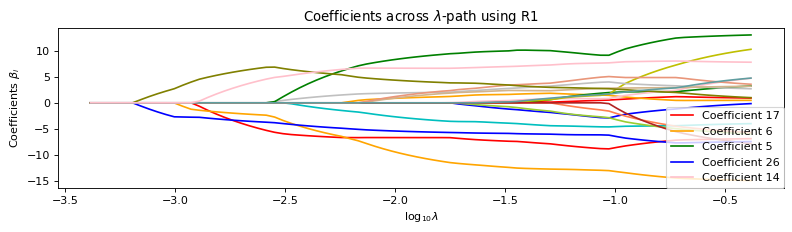

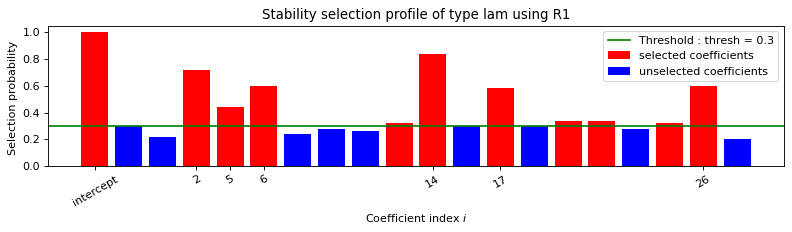

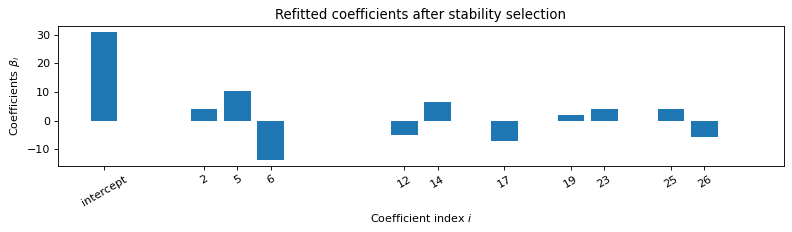


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    6    12    14    17    19    23    25    26    
   Running time :  0.222s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.   -3.31  1.17  0.91 -8.87 14.84  0.13  0.12  0.1   0.09  0.09  4.76
 -0.29 -6.6   0.17  0.16  7.13 -0.24 -2.33 -0.12 -0.11 -0.1  -4.14  0.07
 -3.87  5.9   0.    0.    0.  ]
Error: 2701.93

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 766.33

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3632.17

-----------------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -0.751
Model:                         IV2SLS   Adj. R-squared:                 -0.859
Method:                     Two Stage   F-statistic:                 -0.005145
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:34:32                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.6416    1.8e+07  -8.15e-07      1.0

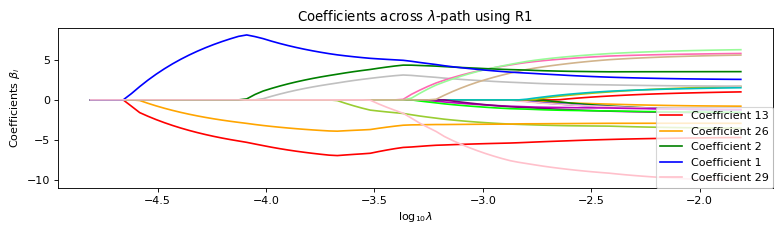

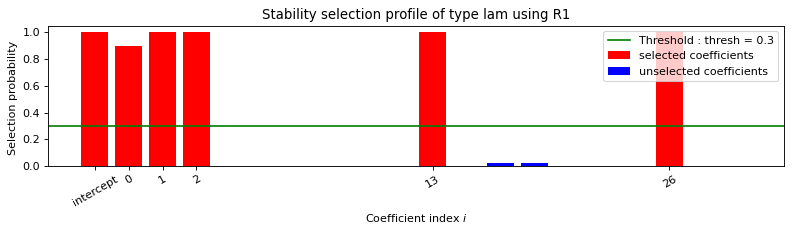

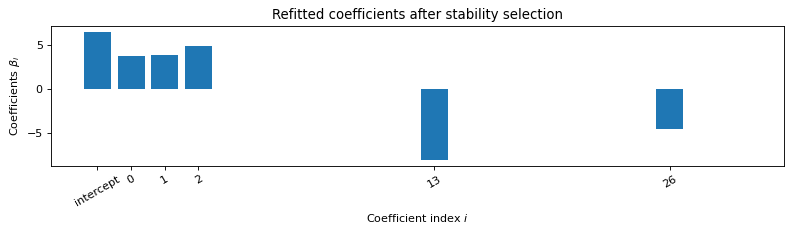


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.086s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.72  3.9   4.93  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -8.03  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.52  0.    0.    0.  ]
Error: 2958.88

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


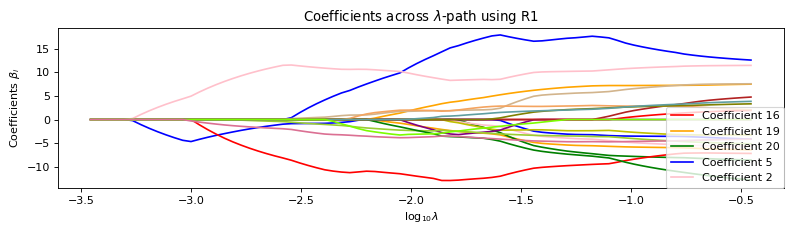

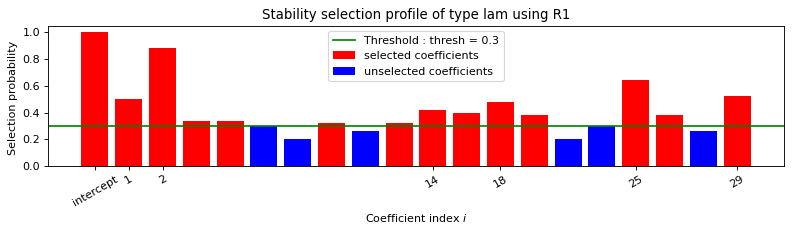

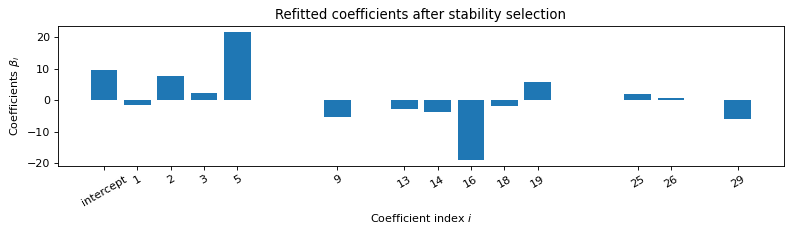


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.014s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    3    5    9    13    14    16    18    19    25    26    29    
   Running time :  0.238s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -1.43   7.56   2.22   0.    21.56   0.     0.     0.    -5.32
   0.     0.     0.    -2.93  -3.63   0.   -18.82   0.    -1.86   5.88
   0.     0.     0.     0.     0.     1.98   0.67   0.     0.    -5.88]
Error: 2569.16

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


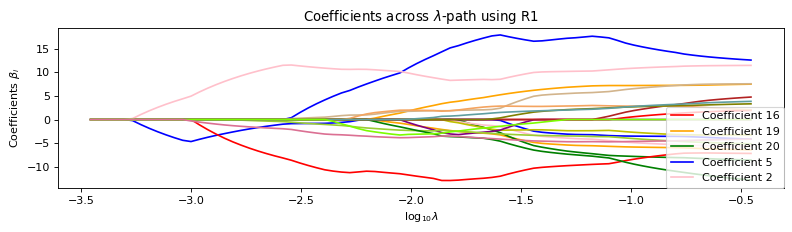

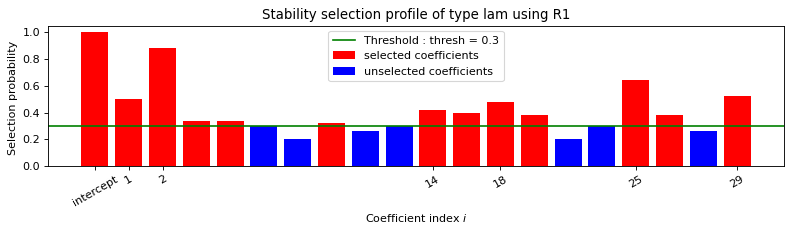

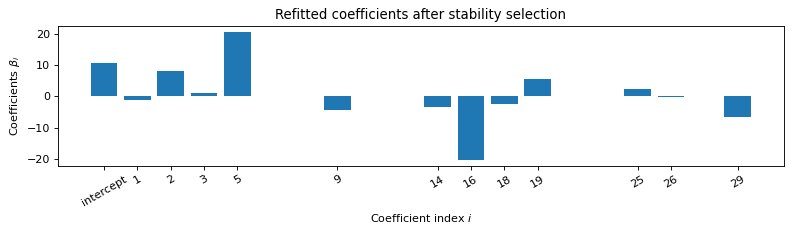


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.012s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    3    5    9    14    16    18    19    25    26    29    
   Running time :  0.247s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.7   -7.18   1.13   1.89 -17.3    4.49   3.89   3.43   7.22   2.36
   2.15   1.98   1.83   4.99   1.38  20.94   0.06   2.47  -5.59   0.21
   0.2    0.19   0.18   0.17  -2.3    0.28   0.24   0.24   6.85]
Error: 2548.48

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 635.72

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 12

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -1.647
Model:                         IV2SLS   Adj. R-squared:                 -1.810
Method:                     Two Stage   F-statistic:                   0.03361
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:37:25                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5138        nan        nan        n

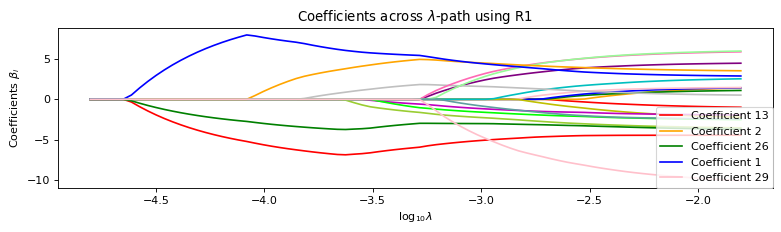

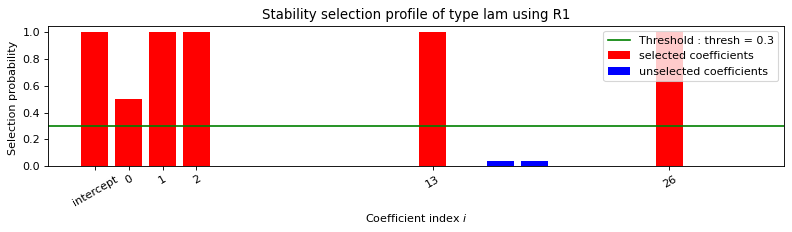

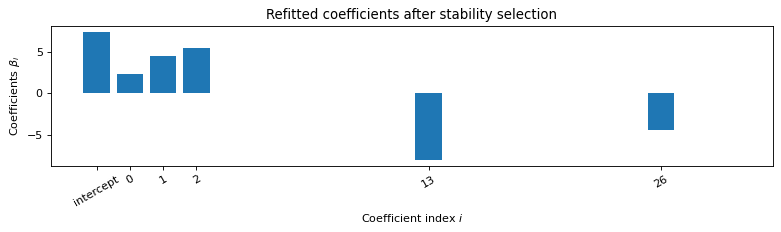


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.037s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.153s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.29  4.51  5.49  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.92  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.37  0.    0.    0.  ]
Error: 3530.38

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


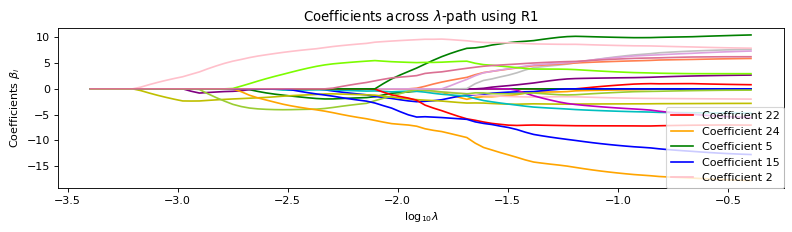

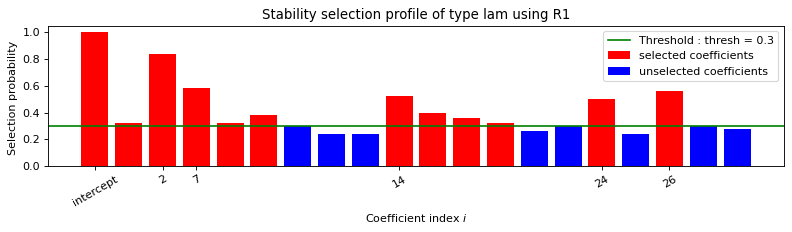

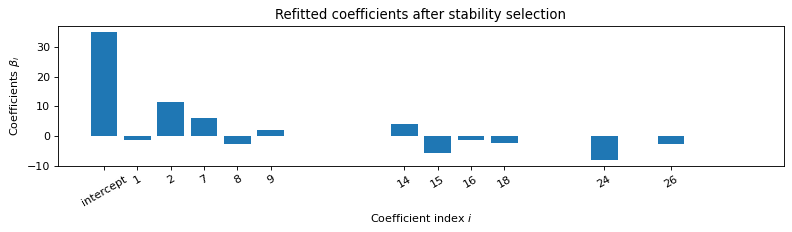


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.013s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    8    9    14    15    16    18    24    26    
   Running time :  0.255s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.   -1.24 11.48  0.    0.    0.    0.    6.11 -2.65  1.94  0.    0.
  0.    0.    4.12 -5.65 -1.36  0.   -2.31  0.    0.    0.    0.    0.
 -7.88  0.   -2.56  0.    0.    0.  ]
Error: 2408.55

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


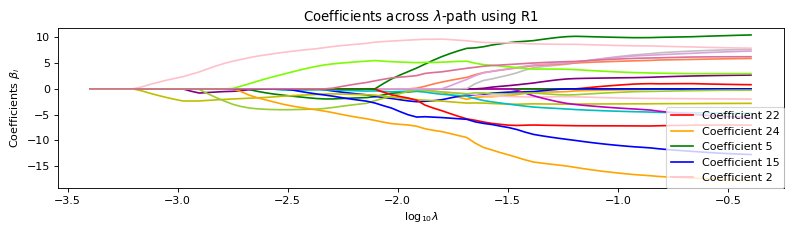

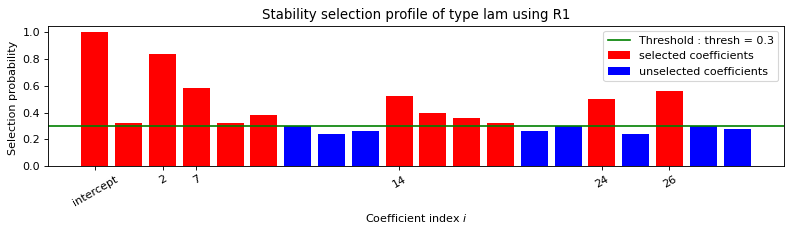

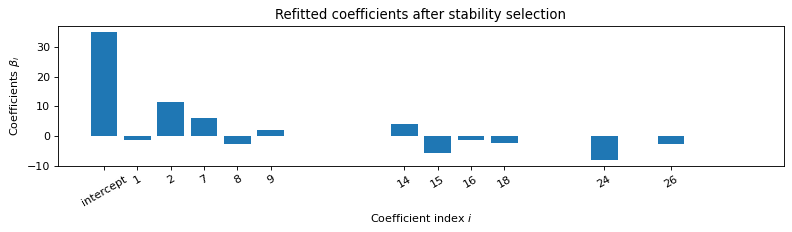


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.012s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    8    9    14    15    16    18    24    26    
   Running time :  0.24s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.88 -9.88  2.96  2.29  1.87  1.58 -4.34  4.43 -0.4   1.49  1.36  1.25
  1.16 -2.9   6.75  2.18  0.73  2.94  0.54  0.51  0.49  0.46  0.44  8.14
  0.1   2.61  0.    0.    0.  ]
Error: 2408.55

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 585.68

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3545.17

--------------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -6.399
Model:                         IV2SLS   Adj. R-squared:                 -6.856
Method:                     Two Stage   F-statistic:                 0.0003506
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:40:34                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.9760        nan        nan        n

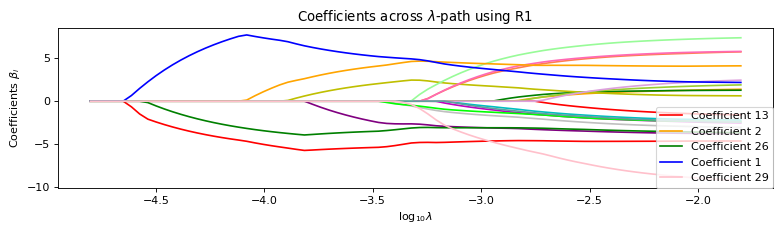

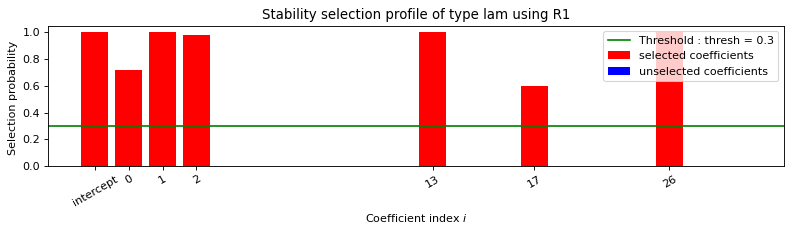

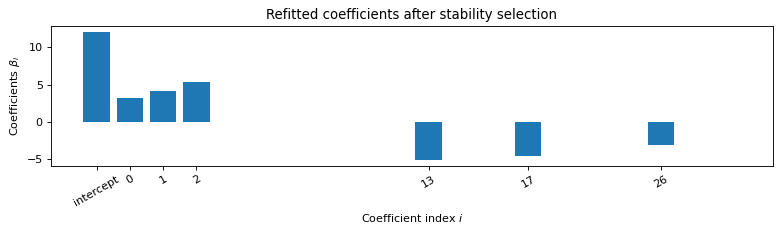


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    17    26    
   Running time :  0.1s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.26  4.14  5.32  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -5.05  0.    0.    0.   -4.55  0.    0.    0.    0.    0.    0.
  0.    0.   -3.11  0.    0.    0.  ]
Error: 3415.04

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


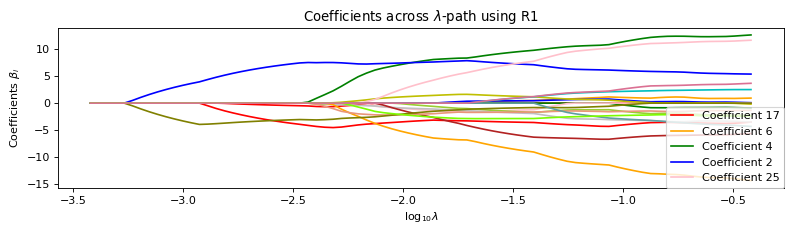

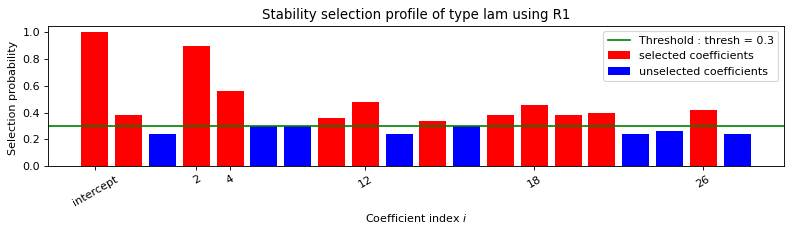

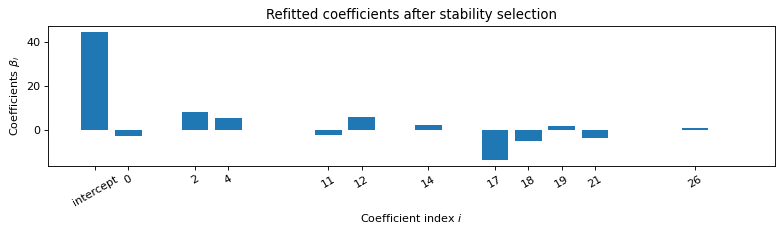


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.021s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    2    4    11    12    14    17    18    19    21    26    
   Running time :  0.28s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -2.47   0.     8.51   0.     5.45   0.     0.     0.     0.     0.
   0.    -1.96   6.     0.     2.57   0.     0.   -13.11  -4.74   1.84
   0.    -3.3    0.     0.     0.     0.     1.2    0.     0.     0.  ]
Error: 2118.94

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


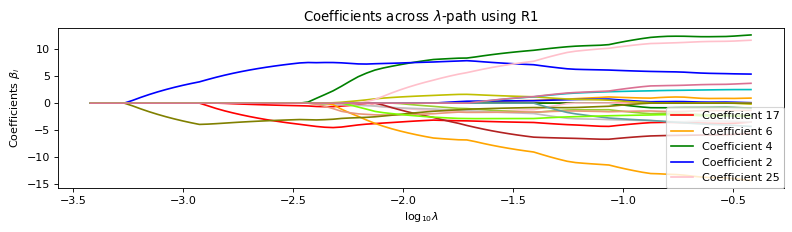

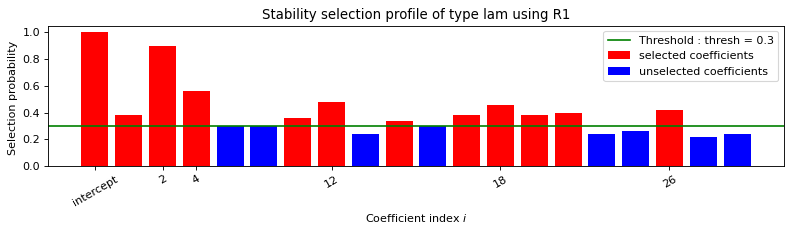

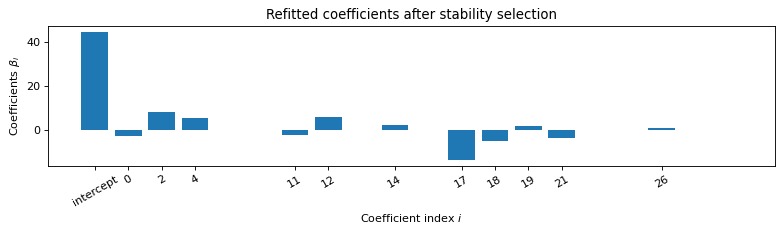


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.012s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    2    4    11    12    14    17    18    19    21    26    
   Running time :  0.215s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-1.75 -7.95  1.74 -3.53  2.1   1.77  1.54  1.35  1.21  1.1   2.88 -5.01
  1.15 -1.41  1.17  1.1  13.78  4.89 -1.78  0.1   3.32 -0.05 -0.05 -0.05
 -0.05 -1.23  0.    0.    0.  ]
Error: 2118.94

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 718.0

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3559.69

------------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                  -13953.743
Model:                         IV2SLS   Adj. R-squared:             -14814.780
Method:                     Two Stage   F-statistic:                 0.0004795
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:43:43                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2672.5867        nan        nan        n

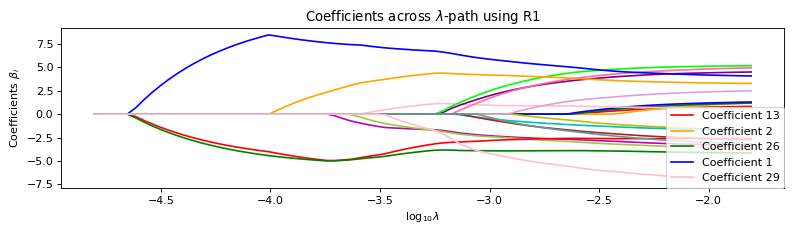

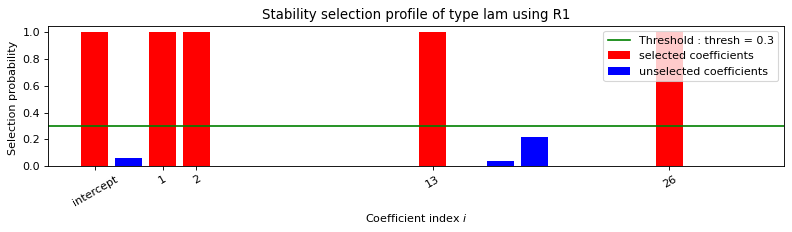

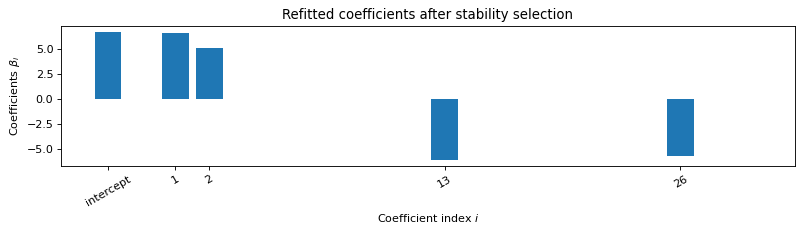


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.11s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    6.58  5.14  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.06  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.66  0.    0.    0.  ]
Error: 3717.3

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


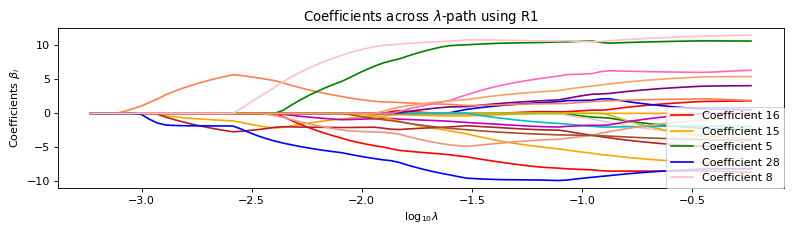

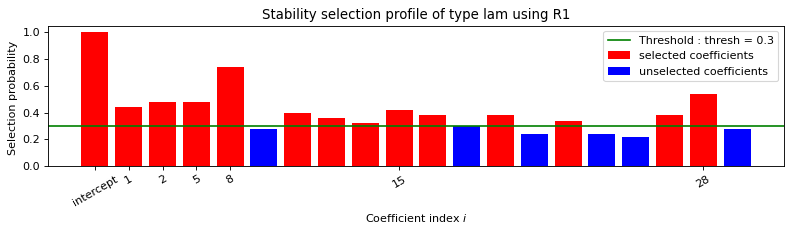

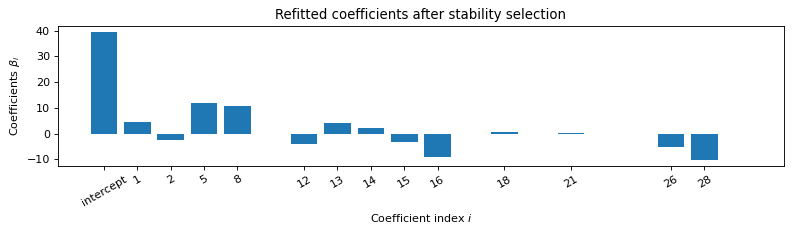


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    8    12    13    14    15    16    18    21    26    28    
   Running time :  0.171s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     4.48  -2.52   0.     0.    11.86   0.     0.    10.63   0.
   0.     0.    -4.04   3.99   2.1   -3.34  -9.06   0.     0.78   0.
   0.     0.3    0.     0.     0.     0.    -5.09   0.   -10.08   0.  ]
Error: 2435.33

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


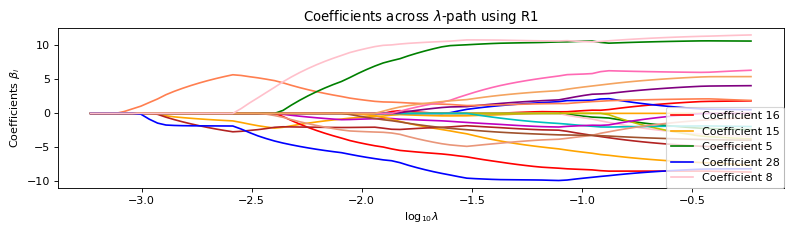

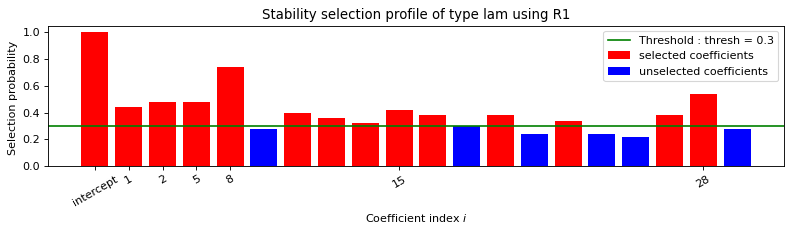

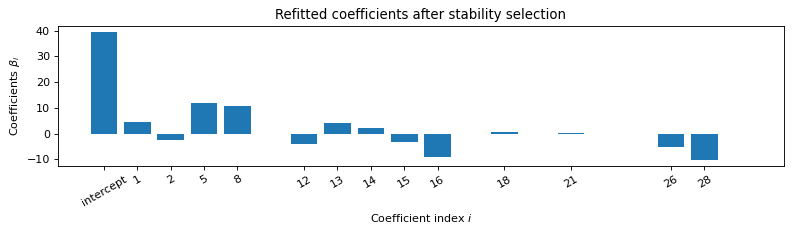


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    8    12    13    14    15    16    18    21    26    28    
   Running time :  0.192s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-3.170e+00  3.890e+00  5.700e-01  4.400e-01 -1.047e+01  2.130e+00
  1.850e+00 -8.390e+00  2.580e+00  2.330e+00  2.130e+00  5.840e+00
 -2.330e+00 -3.500e-01  4.940e+00  1.020e+01  8.100e-01  1.000e-02
  7.600e-01  7.300e-01  4.000e-01  6.700e-01  6.500e-01  6.200e-01
  6.000e-01  5.570e+00  3.700e-01  1.026e+01  0.000e+00]
Error: 2435.27

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2103.22

-----------------------------------------------------------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -6.527
Model:                         IV2SLS   Adj. R-squared:                 -6.992
Method:                     Two Stage   F-statistic:                   0.03606
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:46:37                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.1825        nan        nan        n

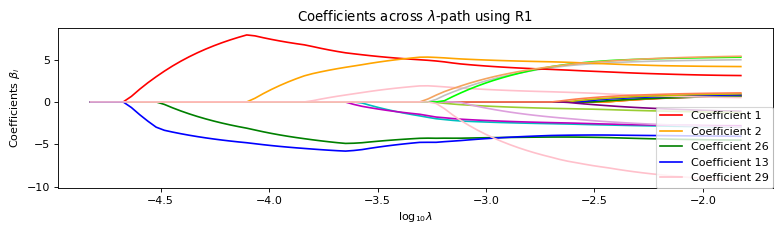

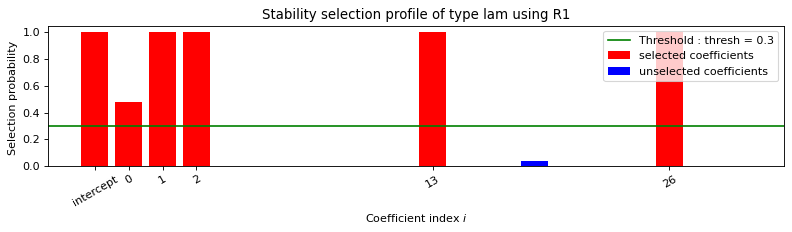

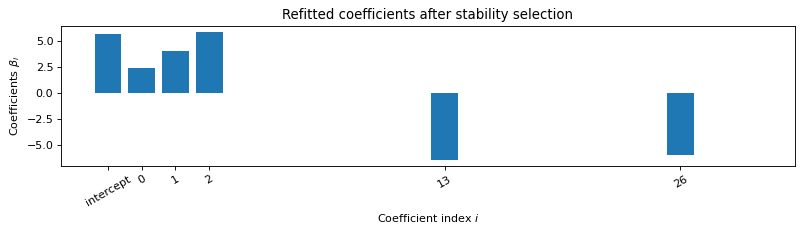


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.112s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.42  4.02  5.87  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.38  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.93  0.    0.    0.  ]
Error: 3531.6

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


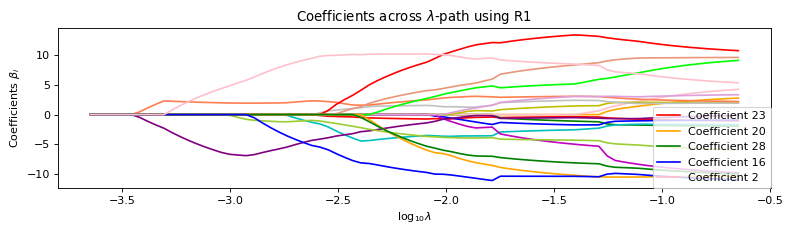

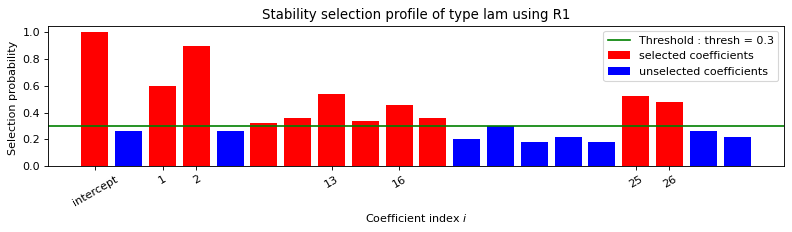

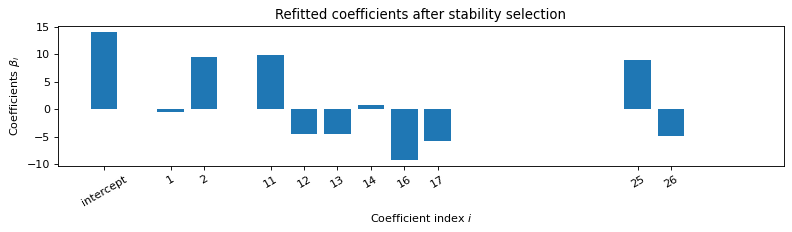


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    11    12    13    14    16    17    25    26    
   Running time :  0.161s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.   -0.45  9.59  0.    0.    0.    0.    0.    0.    0.    0.    9.87
 -4.58 -4.53  0.86  0.   -9.14 -5.73  0.    0.    0.    0.    0.    0.
  0.    9.01 -4.89  0.    0.    0.  ]
Error: 3298.58

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


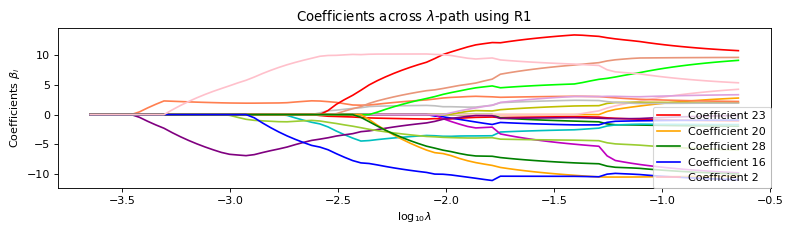

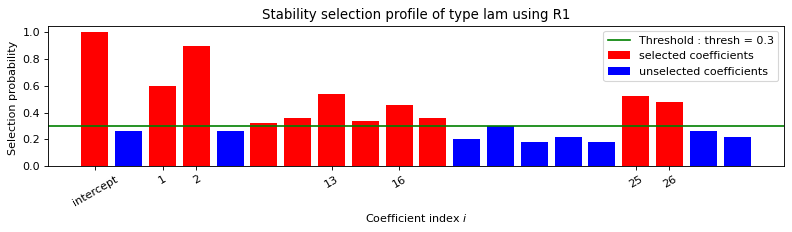

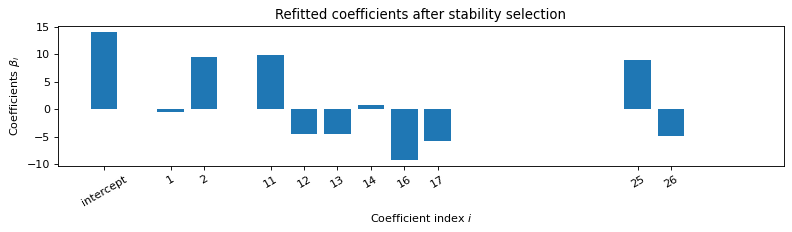


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    11    12    13    14    16    17    25    26    
   Running time :  0.134s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.32 -8.01  2.64  2.04  1.67  1.41  1.22  1.08  0.96  0.87 -8.66  5.92
  5.44 -0.15  0.69  9.52  5.66 -0.22 -0.21 -0.2  -0.19 -0.18 -0.18 -0.17
 -9.    4.99  0.    0.    0.  ]
Error: 3298.58

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 1156.6

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3552.51

----------------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -21.893
Model:                         IV2SLS   Adj. R-squared:                -23.305
Method:                     Two Stage   F-statistic:                   0.01256
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:49:14                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.5974   1.74e+08   3.25e-07      1.0

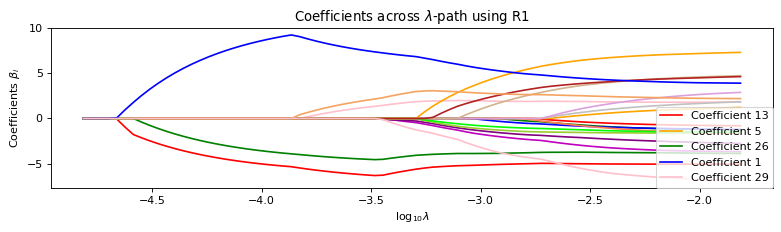

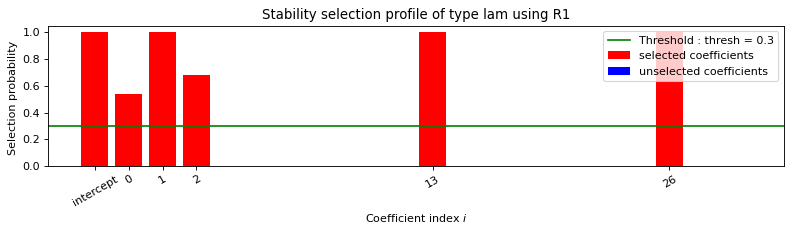

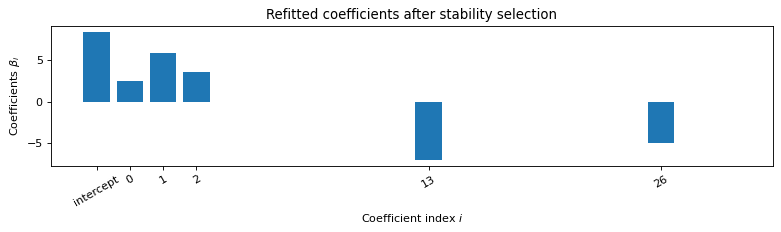


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.103s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.47  5.96  3.59  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.01  0.    0.    0.  ]
Error: 3641.51

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


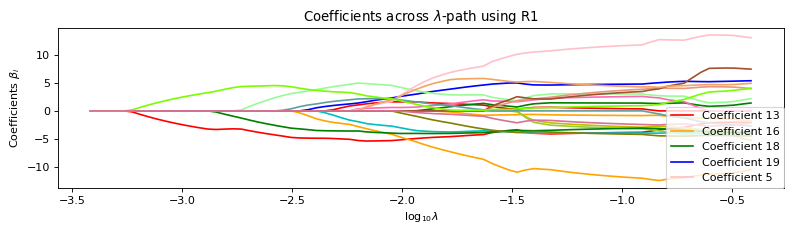

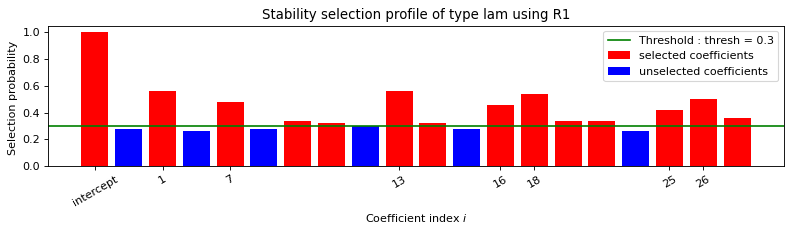

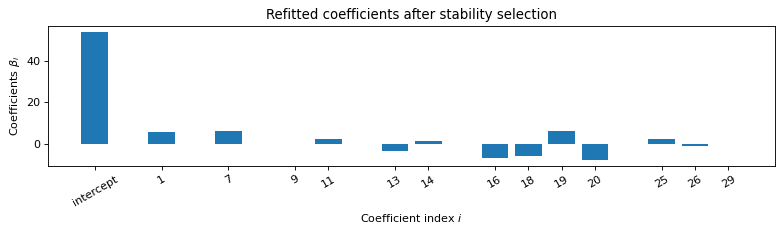


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    7    9    11    13    14    16    18    19    20    25    26    29    
   Running time :  0.2s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    5.63  0.    0.    0.    0.    0.    6.02  0.   -0.05  0.    2.41
  0.   -3.32  1.38  0.   -6.7   0.   -5.57  6.06 -7.48  0.    0.    0.
  0.    2.5  -0.97  0.    0.    0.08]
Error: 2292.9

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


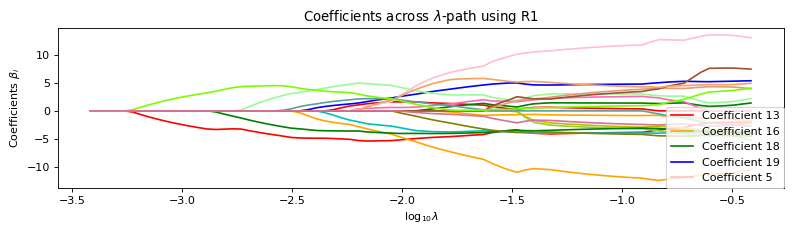

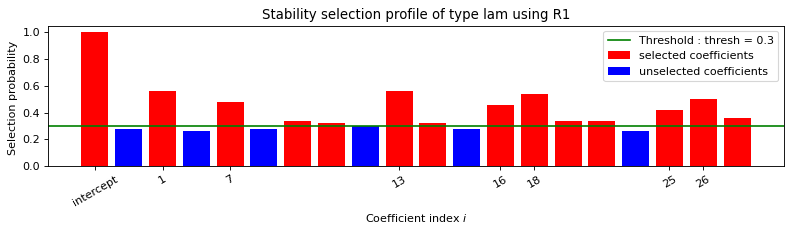

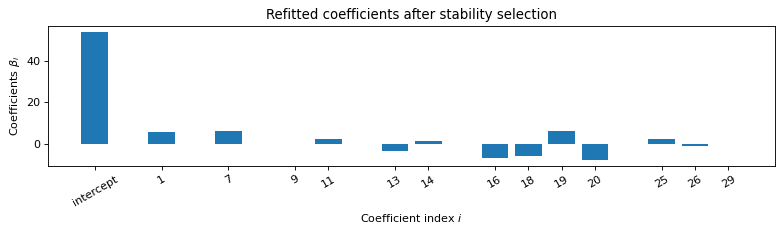


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    7    9    11    13    14    16    18    19    20    25    26    29    
   Running time :  0.222s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-3.98  2.3   1.63  1.26  1.03  0.87 -4.88  1.37  1.28  1.11 -1.3   1.12
  4.24 -0.6   0.78  7.23  0.31  5.71 -5.92  7.59 -0.08 -0.07 -0.07 -0.07
 -2.52  0.99  0.    0.   -0.09]
Error: 2292.9

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 1054.7

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3748.03



/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -19.155
Model:                         IV2SLS   Adj. R-squared:                -20.398
Method:                     Two Stage   F-statistic:                 -0.001445
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:51:52                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.6714        nan        nan        n

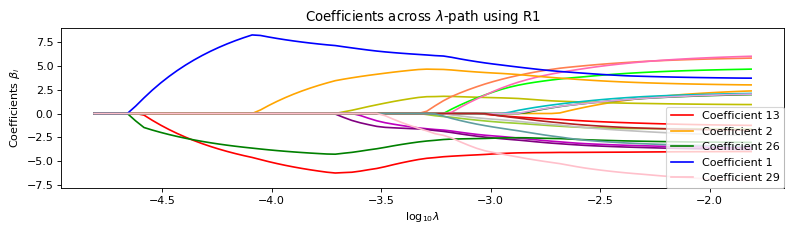

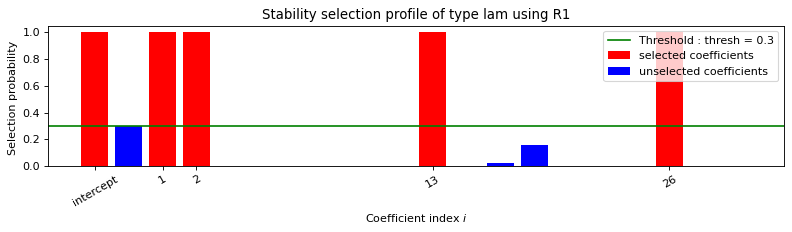

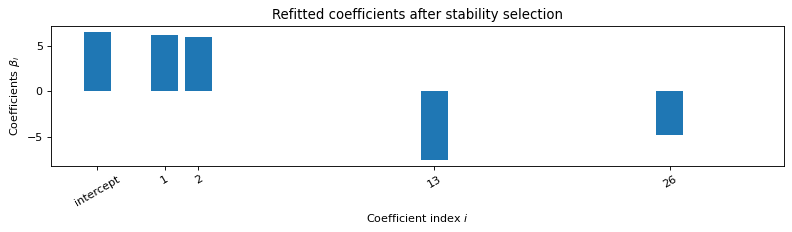


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.088s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    6.24  6.01  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.48  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.77  0.    0.    0.  ]
Error: 3893.24

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


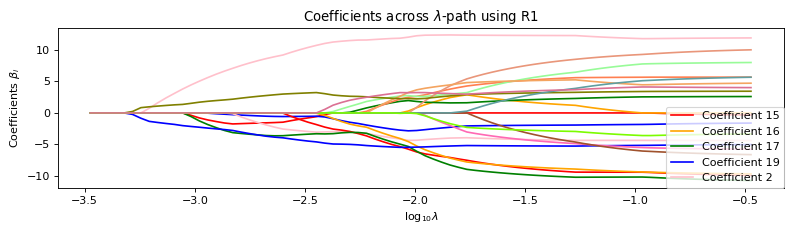

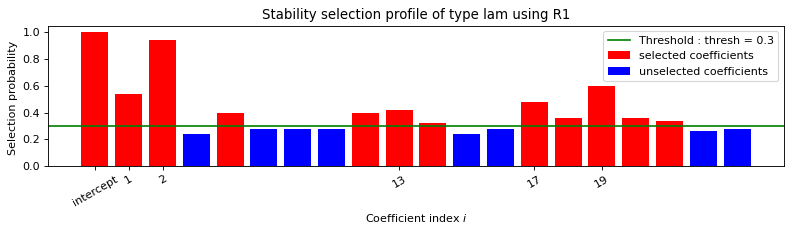

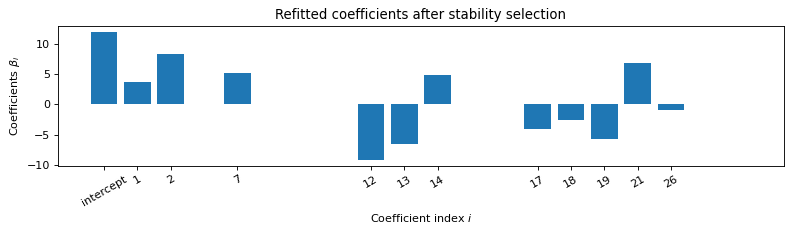


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    17    18    19    21    26    
   Running time :  0.205s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    3.71  8.27  0.    0.    0.    0.    5.12  0.    0.    0.    0.
 -9.08 -6.52  4.85  0.    0.   -4.09 -2.63 -5.64  0.    6.88  0.    0.
  0.    0.   -0.88  0.    0.    0.  ]
Error: 3732.05

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


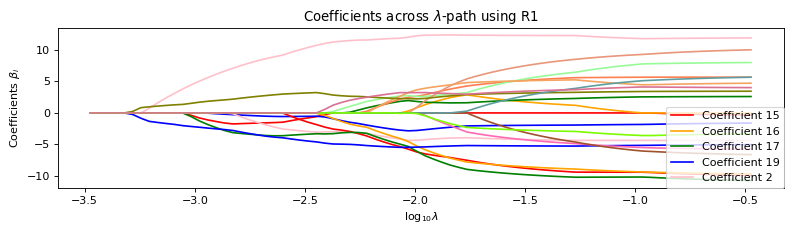

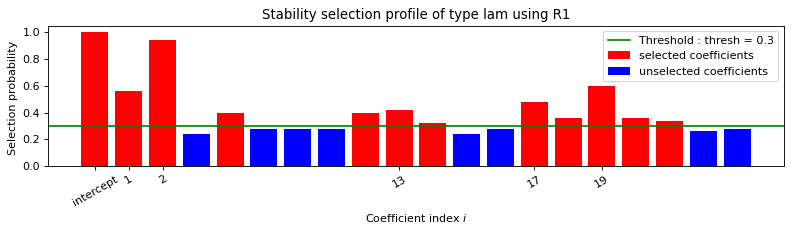

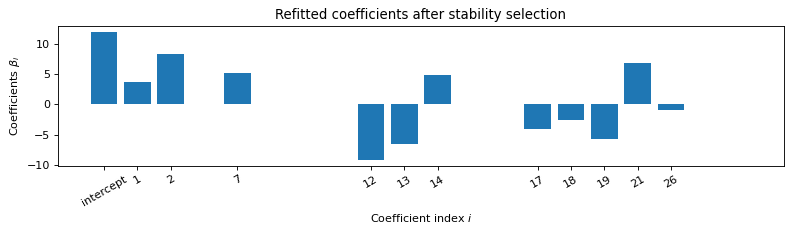


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    17    18    19    21    26    
   Running time :  0.153s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-2.62 -5.24  3.46  2.68  2.19  1.85 -3.18  2.02  1.8   1.63  1.49 10.1
  6.87 -4.58  0.41  0.39  4.33  2.68  5.48 -0.29 -7.01  0.04  0.04  0.04
  0.03  0.9   0.    0.    0.  ]
Error: 3732.05

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 610.99

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3910.04

------------

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -10.247
Model:                         IV2SLS   Adj. R-squared:                -10.941
Method:                     Two Stage   F-statistic:                  -0.01109
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:54:27                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.9642   2.04e+08  -4.88e-08      1.0

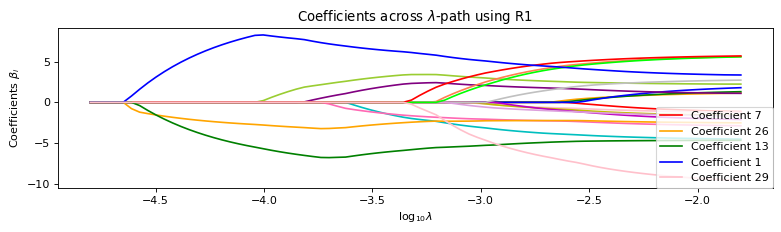

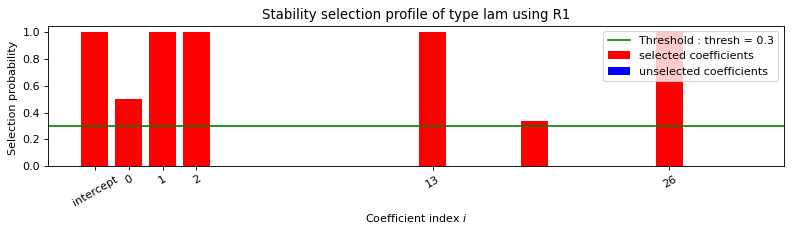

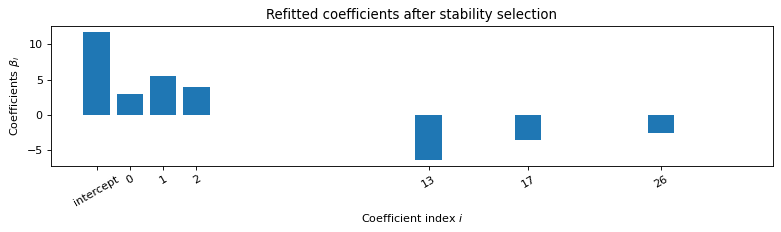


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    17    26    
   Running time :  0.119s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.99  5.51  4.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.38  0.    0.    0.   -3.56  0.    0.    0.    0.    0.    0.
  0.    0.   -2.56  0.    0.    0.  ]
Error: 3437.11

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


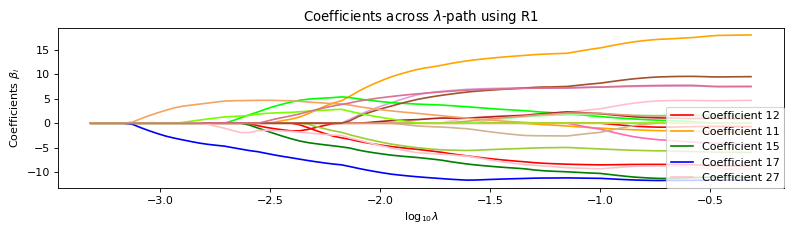

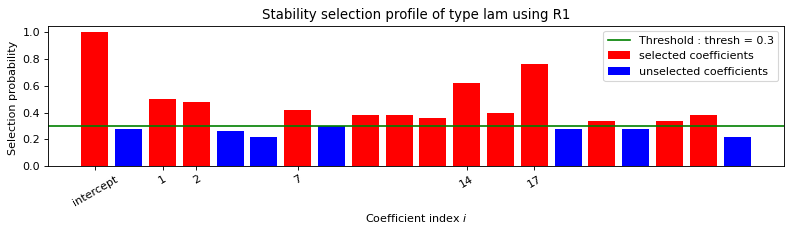

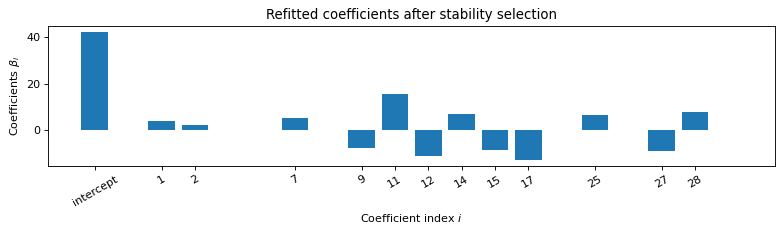


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    9    11    12    14    15    17    25    27    28    
   Running time :  0.188s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     4.15   2.36   0.     0.     0.     0.     5.47   0.    -7.71
   0.    15.55 -10.91   0.     6.89  -8.42   0.   -12.52   0.     0.
   0.     0.     0.     0.     0.     6.45   0.    -9.02   7.72   0.  ]
Error: 2393.42

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


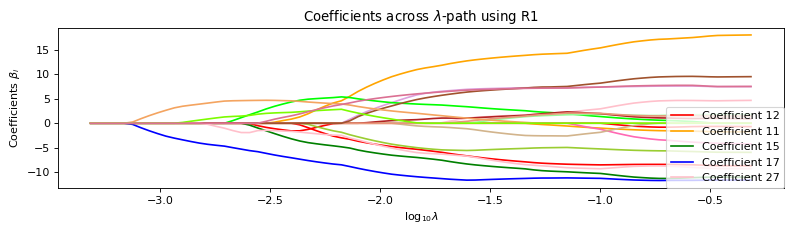

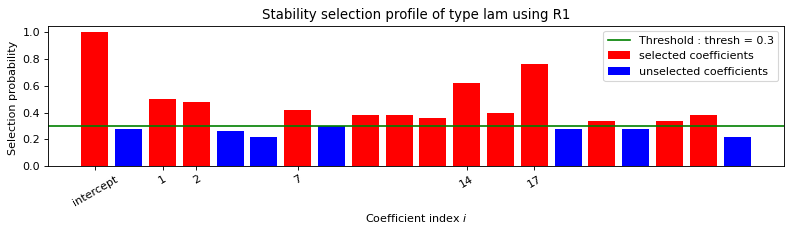

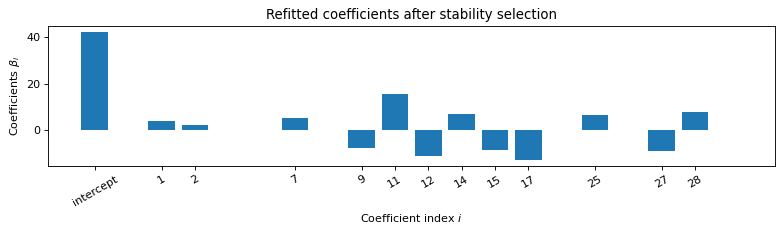


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.012s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    9    11    12    14    15    17    25    27    28    
   Running time :  0.2s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -2.94  -0.23   1.88   1.45   1.19   1.    -4.25   1.41   8.57   0.41
 -14.52  12.07   0.66  -6.04   9.18   0.45  12.58  -0.28  -0.26  -0.25
  -0.24  -0.23  -0.22  -0.21  -6.52   0.05   8.91  -7.86   0.  ]
Error: 2393.37

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 936.53

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 12

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                 -132981.433
Model:                         IV2SLS   Adj. R-squared:            -141186.732
Method:                     Two Stage   F-statistic:                -8.068e-05
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:57:08                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3702.5601   2.64e+10    1.4e-07      1.0

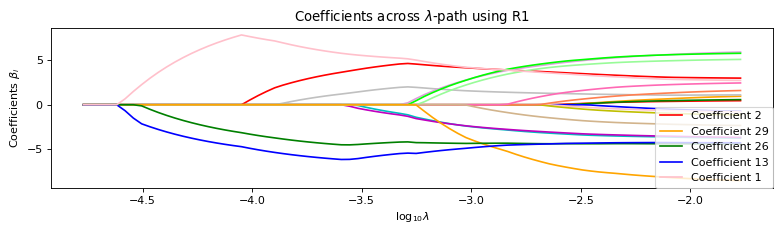

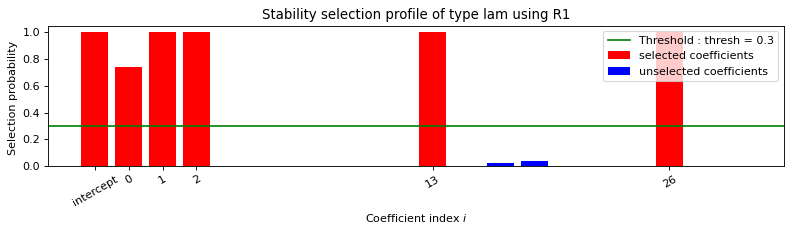

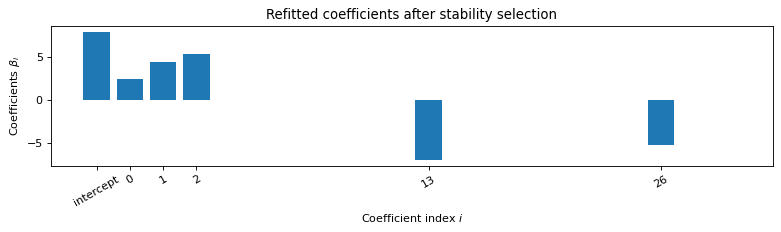


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.079s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.43  4.4   5.36  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.93  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.27  0.    0.    0.  ]
Error: 3267.01

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


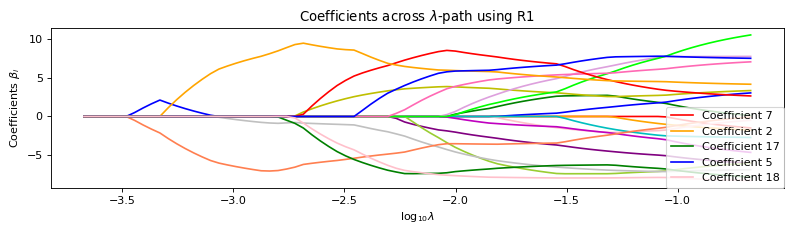

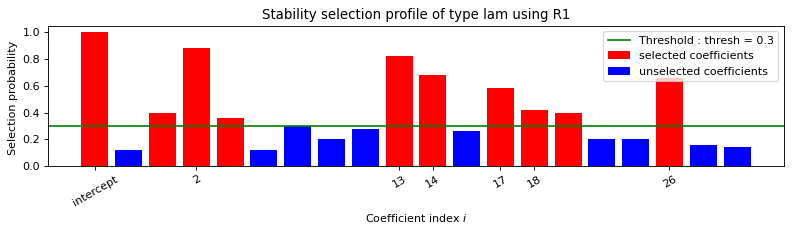

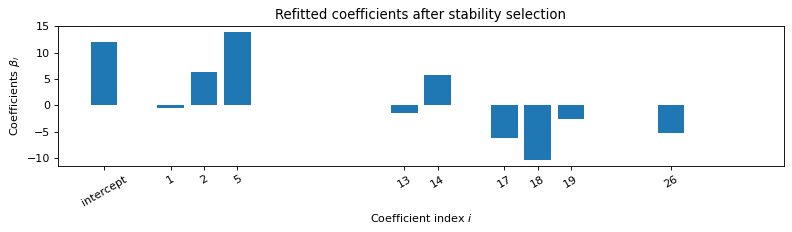


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    13    14    17    18    19    26    
   Running time :  0.18s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -0.54   6.32   0.     0.    13.92   0.     0.     0.     0.
   0.     0.     0.    -1.48   5.82   0.     0.    -6.11 -10.25  -2.54
   0.     0.     0.     0.     0.     0.    -5.14   0.     0.     0.  ]
Error: 2664.7

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


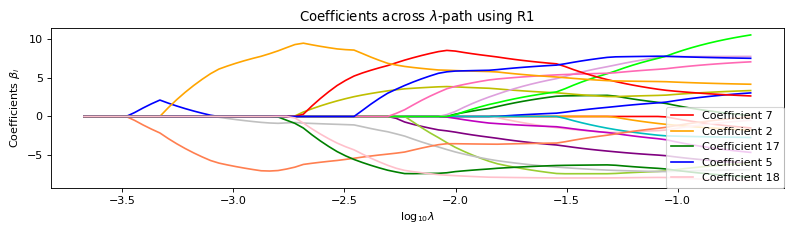

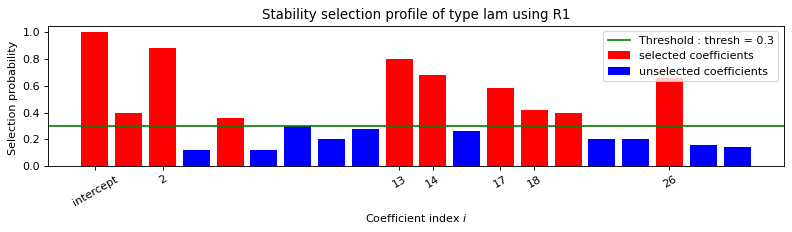

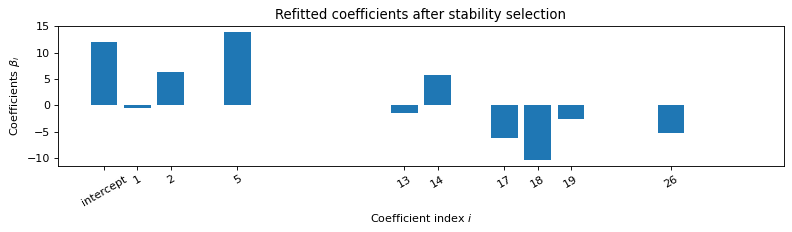


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    5    13    14    17    18    19    26    
   Running time :  0.133s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.38  -5.38   1.67   1.29 -11.65   3.04   2.63   2.32   2.08   1.88
   1.71   1.58   2.88  -4.37   1.55   1.46   7.31  10.95   2.87   0.25
   0.24   0.23   0.22   0.21   0.2    5.24   0.     0.     0.  ]
Error: 2664.7

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 954.95

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3249

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                    -369.122
Model:                         IV2SLS   Adj. R-squared:               -391.960
Method:                     Two Stage   F-statistic:                 1.027e-14
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        18:59:41                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -343.3052        nan        nan        n

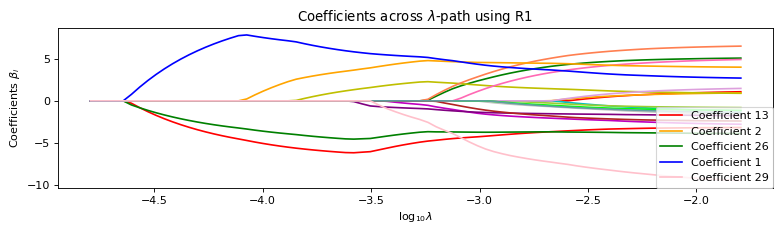

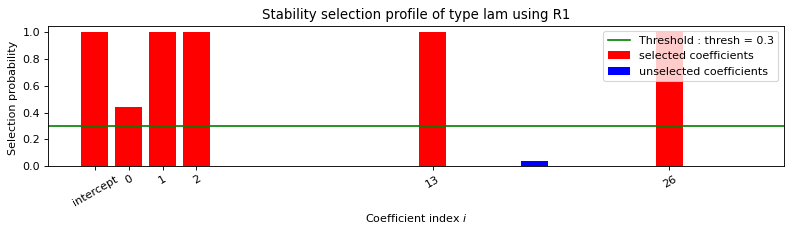

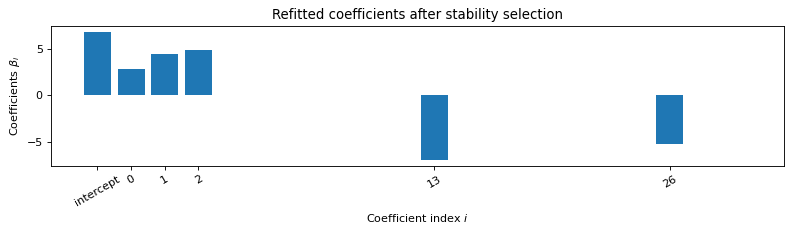


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.077s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.84  4.43  4.92  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.92  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.27  0.    0.    0.  ]
Error: 3399.77

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


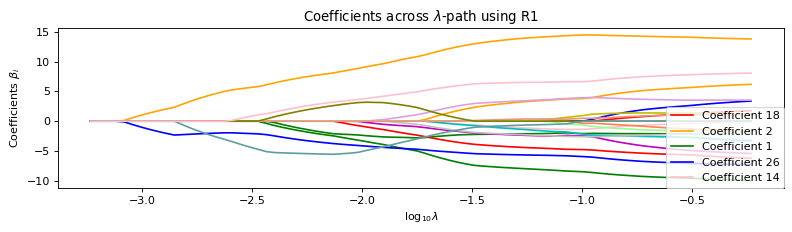

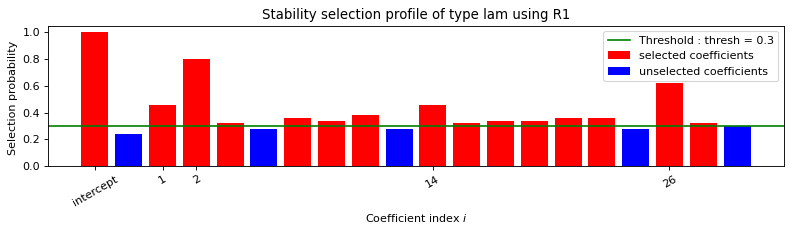

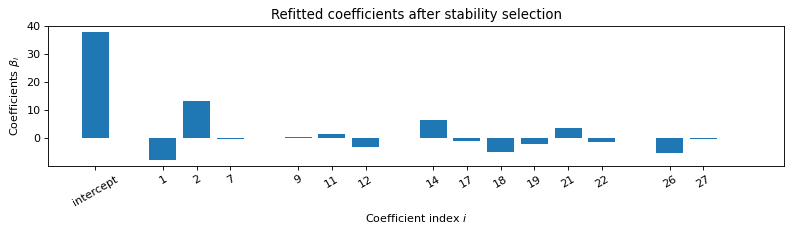


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    9    11    12    14    17    18    19    21    22    26    27    
   Running time :  0.206s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.   -7.57 13.44  0.    0.    0.    0.   -0.38  0.    0.47  0.    1.49
 -3.22  0.    6.64  0.    0.   -1.08 -4.8  -2.    0.    3.65 -1.32  0.
  0.    0.   -5.23 -0.1   0.    0.  ]
Error: 1964.4

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


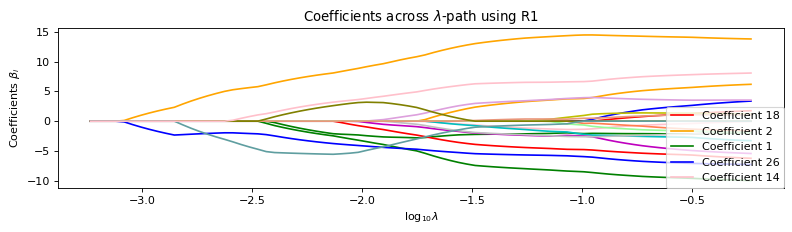

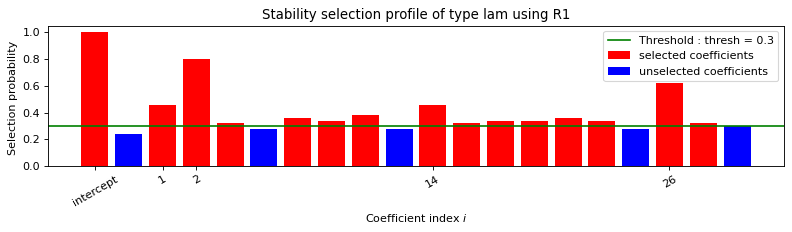

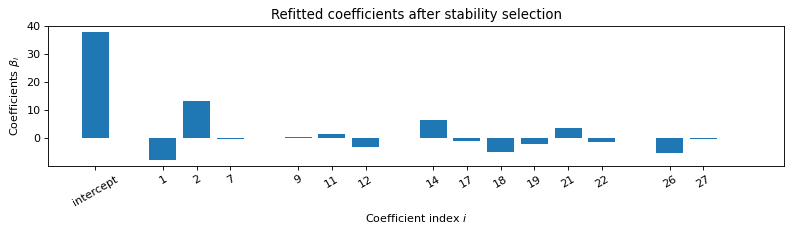


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    9    11    12    14    17    18    19    21    22    26    27    
   Running time :  0.204s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  5.35 -14.06   1.7    1.31   1.07   0.91   1.14   0.65   0.14   0.57
  -0.91   3.69   0.31  -6.12   0.7    0.66   1.67   5.2    2.2    0.15
  -3.43   1.59   0.23   0.22   0.21   5.33   0.1    0.     0.  ]
Error: 1964.4

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 977.86

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                       0.215
Model:                         IV2SLS   Adj. R-squared:                  0.166
Method:                     Two Stage   F-statistic:                  0.001401
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        19:02:17                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.3247        nan        nan        n

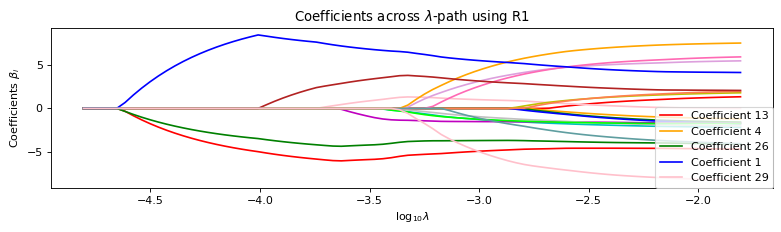

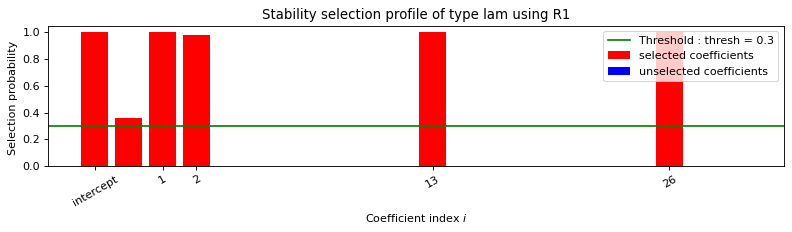

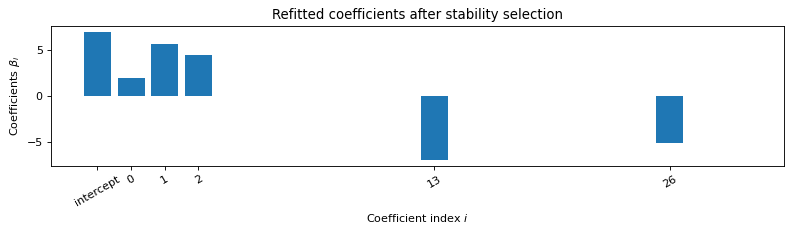


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.012s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.096s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 1.91  5.67  4.43  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.91  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.1   0.    0.    0.  ]
Error: 3623.83

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


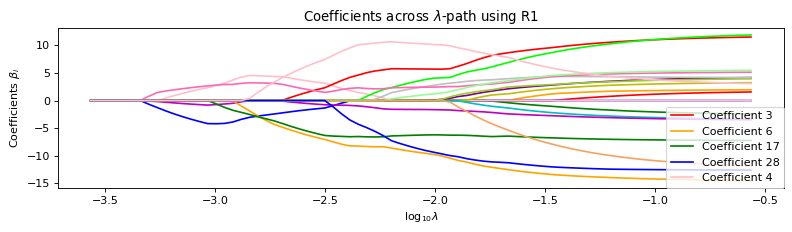

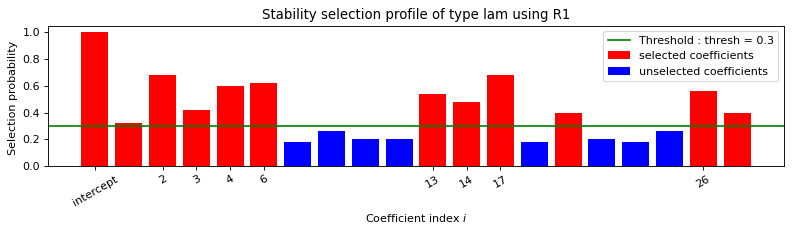

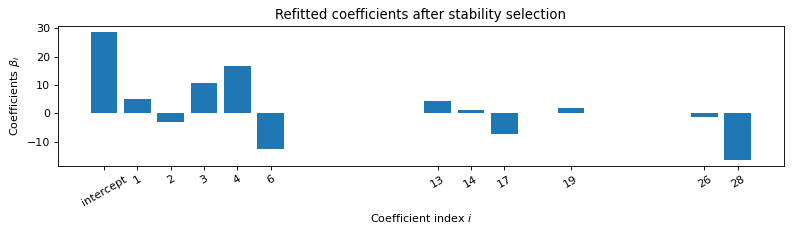


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    3    4    6    13    14    17    19    26    28    
   Running time :  0.168s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     5.12  -3.13  10.76  16.86   0.   -12.53   0.     0.     0.
   0.     0.     0.     4.45   1.24   0.     0.    -7.13   0.     1.81
   0.     0.     0.     0.     0.     0.    -1.19   0.   -16.25   0.  ]
Error: 3096.77

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


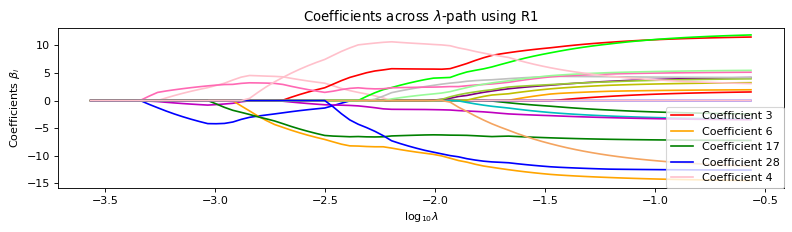

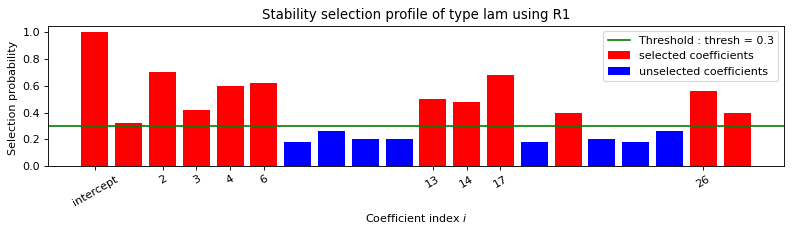

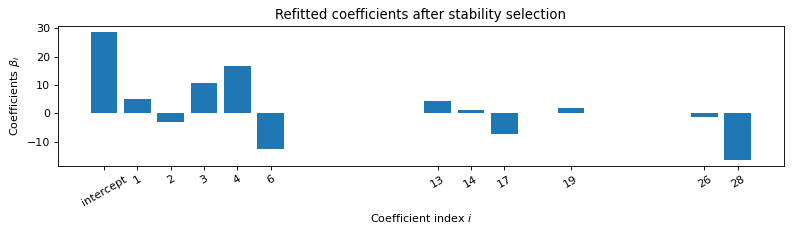


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    3    4    6    13    14    17    19    26    28    
   Running time :  0.205s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -3.62   4.65  -8.74 -12.23   5.4   16.17   2.28   2.01   1.8    1.63
   1.49   1.37  -3.02   0.29   1.47   1.38   8.23   0.84  -0.96   0.85
   0.81   0.77   0.74   0.71   0.68   1.82   0.59  16.53   0.  ]
Error: 3096.64

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 977.5

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
E

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -2.379
Model:                         IV2SLS   Adj. R-squared:                 -2.587
Method:                     Two Stage   F-statistic:                   0.03207
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        19:04:54                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.3854        nan        nan        n

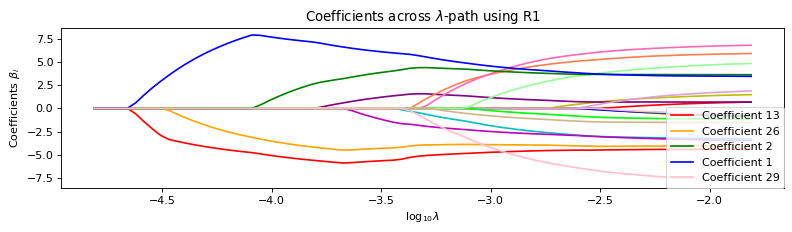

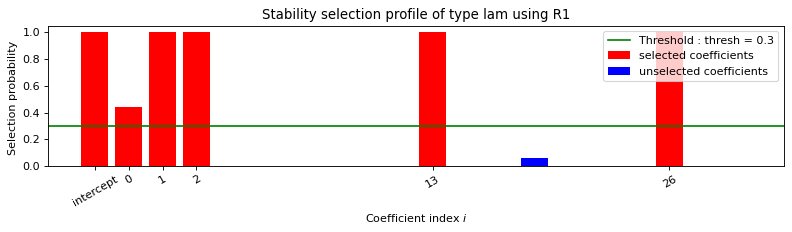

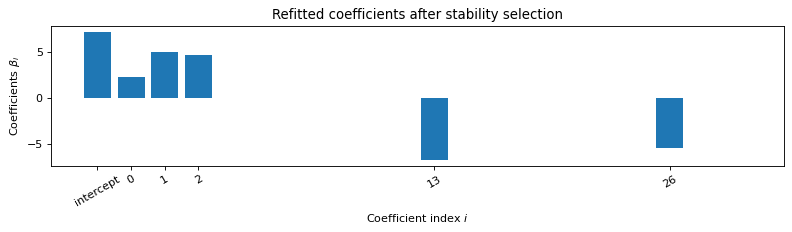


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.075s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.31  5.07  4.67  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.67  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.38  0.    0.    0.  ]
Error: 3395.39

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


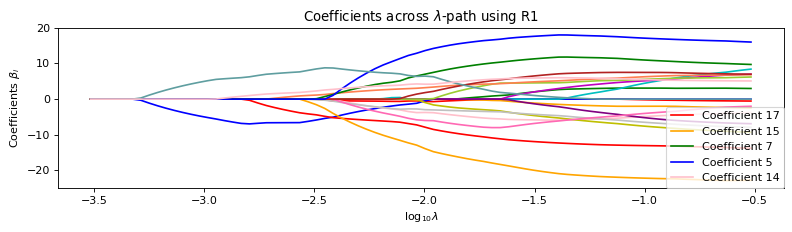

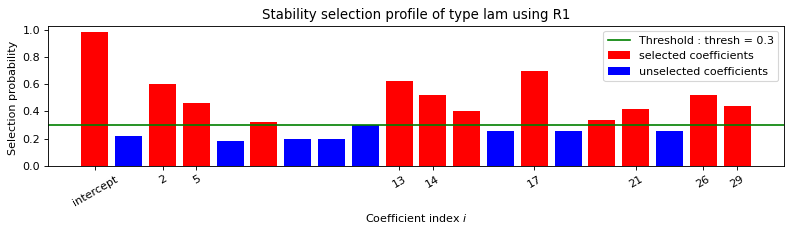

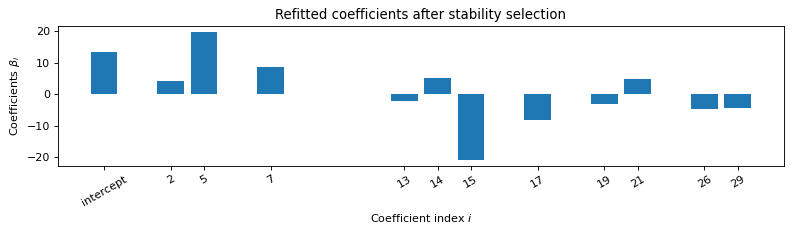


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    7    13    14    15    17    19    21    26    29    
   Running time :  0.188s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     0.     4.38   0.     0.    19.75   0.     8.81   0.     0.
   0.     0.     0.    -2.19   5.24 -20.72   0.    -8.25   0.    -2.96
   0.     4.92   0.     0.     0.     0.    -4.78   0.     0.    -4.21]
Error: 3562.5

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


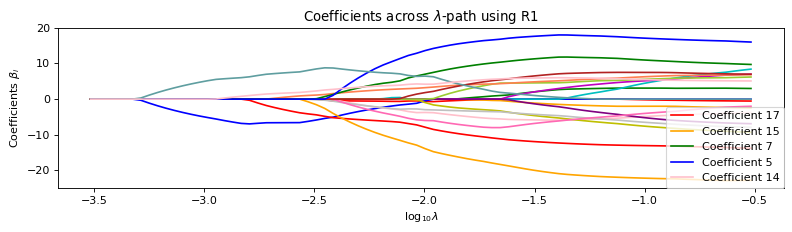

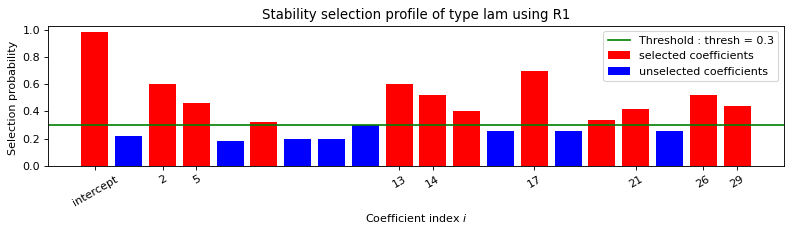

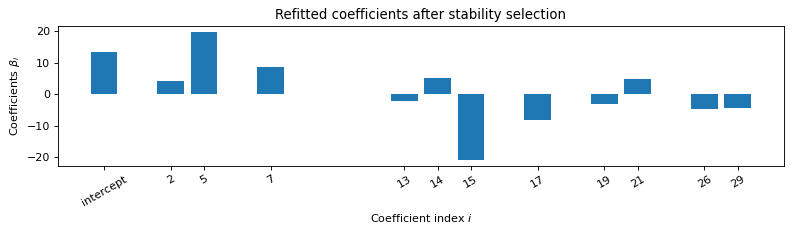


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    7    13    14    15    17    19    21    26    29    
   Running time :  0.174s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -3.57   1.26   0.98 -17.23   3.72  -5.02   3.88   3.47   3.14
   2.87   2.64   4.55  -2.94  22.38   0.93   8.89   0.38   3.24   0.2
  -4.62   0.4    0.38   0.37   0.35   5.02   0.15   0.15   4.28]
Error: 3562.51

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 1725.0

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 12

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                   -1698.757
Model:                         IV2SLS   Adj. R-squared:              -1803.636
Method:                     Two Stage   F-statistic:                 0.0007059
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        19:07:32                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.2163   2.33e+09   7.02e-08      1.0

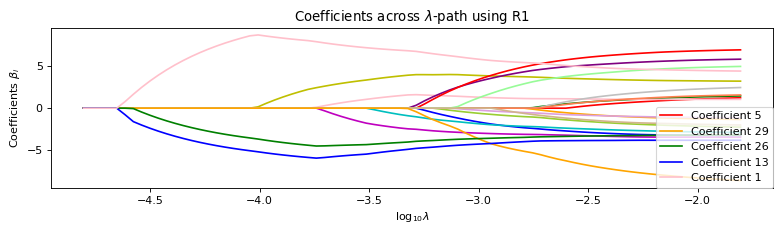

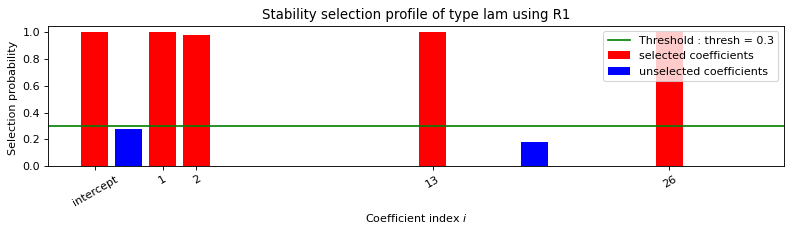

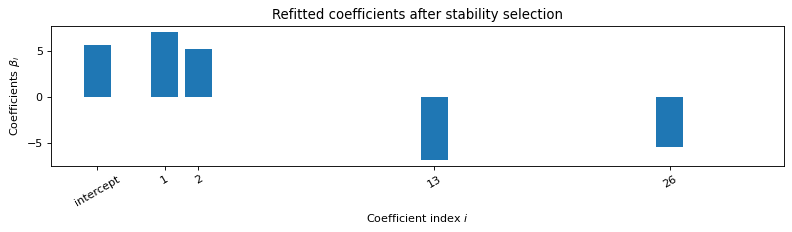


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.064s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    7.06  5.24  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.83  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.47  0.    0.    0.  ]
Error: 4128.97

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


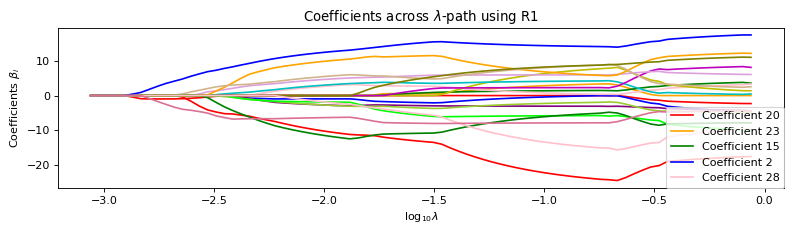

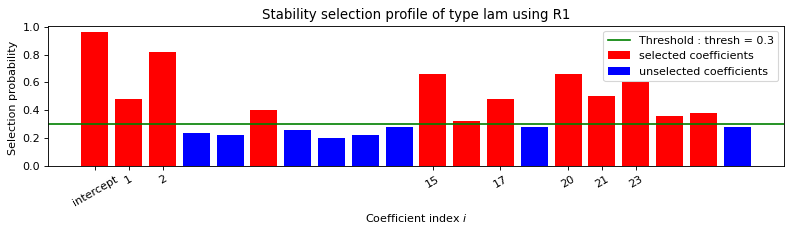

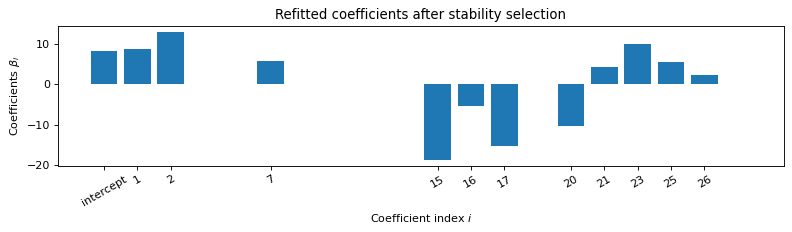


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    15    16    17    20    21    23    25    26    
   Running time :  0.169s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     8.79  12.87   0.     0.     0.     0.     5.69   0.     0.
   0.     0.     0.     0.     0.   -18.59  -5.28 -15.18   0.     0.
 -10.21   4.27   0.     9.94   0.     5.38   2.32   0.     0.     0.  ]
Error: 6040.78

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


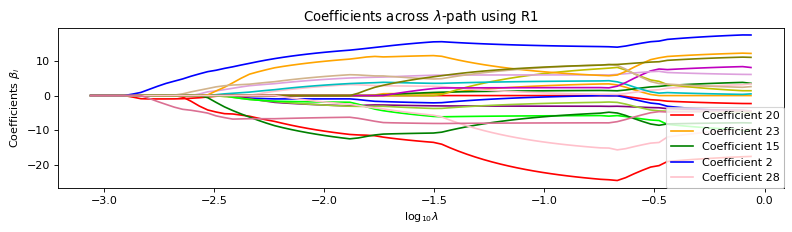

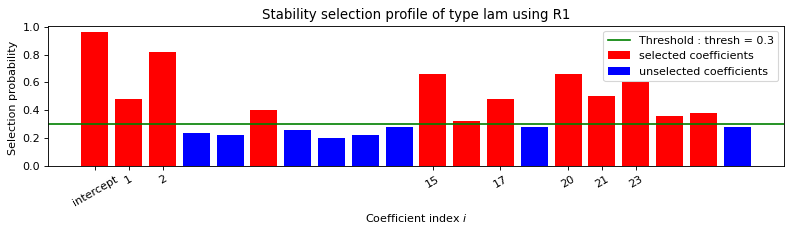

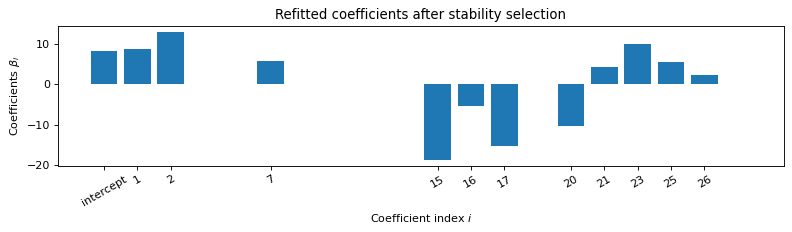


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    15    16    17    20    21    23    25    26    
   Running time :  0.169s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -6.22  -6.92   6.25   4.84   3.95   3.34  -2.43   3.22   2.88   2.61
   2.38   2.19   2.03   1.89  19.77   5.65  14.95  -0.63  -0.6    9.39
  -5.19  -0.78 -10.48  -0.31  -5.57  -2.36   0.     0.     0.  ]
Error: 6040.72

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Error: 746.52

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -68.139
Model:                         IV2SLS   Adj. R-squared:                -72.405
Method:                     Two Stage   F-statistic:                 0.0005519
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Fr, 11 Jun 2021                                         
Time:                        19:09:54                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -125.4913        nan        nan        n

In [14]:
today = datetime.now()
num_iteration = 20

path = os.getcwd()
mypath = os.path.join(path, "temp",
                      today.strftime("%Y_%m_%d_%H_%M") + "_Logcontrast_ConfidenceInterval_"+str(instrument_strength)
                      +"_"+ str(num_iteration)+"_Microbiota_" +str(p))

if not os.path.isdir(mypath):
    os.makedirs(mypath)


# create logging file with relevant information
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M',
                    filename=os.path.join(os.getcwd(), mypath, "configurations.log"),
                    filemode='w'
                    )

logging.info("n="+str(n)+", p="+str(p)+", instrument strength: "+instrument_strength)
logging.info("Number of runs: "+str(num_iteration))
logging.info("First Stage Specification: ")
logging.info("Number of Instruments: "+str(num_inst))
logging.info("Instrument Strength by F-Test: " +str(F))
logging.info("alpha0="+str(alpha0)+", alphaT="+str(alphaT)+", confounder multiplicator c_X="+str(c_X))
logging.info("Second Stage Specification: ")
logging.info("beta0="+str(beta0)+", betaT="+str(betaT)+", confounder multiplicator c_Y="+str(c_Y))
logging.info("Confounder mean mu_c="+str(mu_c))


df_beta, df_mse, mse_large_confidence= run_methods_confidence_interval(
    key, num_iteration, 
    n, p, num_inst, mu_c, c_X, alpha0, alphaT, c_Y, beta0, betaT, is_lognormal=True, num_star=num_star, 
    logcontrast_threshold=0.3)

In [15]:
import pickle
results = {
    "df_mse": df_mse,
    "df_beta": df_beta,
    "mse_large": mse_large_confidence
}

with open(os.path.join(savepath, "results_"+str(p)+str(instrument_strength)+".pickle"), "wb") as f:
    pickle.dump(results, f)
    f.close()


In [24]:
with open(os.path.join(savepath, "results_"+str(p)+str(instrument_strength)+".pickle"), "rb") as f:
    results = pickle.load(f)
    df_mse = results["df_mse"]
    f.close()


# Mean Squarred Error Plot

In [65]:
df_mse.Method=df_mse.Method.replace({"KIV+KIV":"KIV"})

In [69]:
filter_list = ["ALR+LC", "ONLY Second LC", "KIV"]

fig = plot_mse_results(df_mse, filter_list, sort_to_filter=True)
fig.update_yaxes(range=(0, 4000))
fig.write_image(os.path.join(savepath,
                             "MSE_Small_NegBinom" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))
fig.show()

In [70]:
filter_list = ["ALR+LC", "ILR+LC", "ILR+ILR", "DIR+LC",  "ONLY Second LC", "ONLY Second ILR", "KIV"]

fig = plot_mse_results(df_mse, filter_list, sort_to_filter=True)
fig.update_yaxes(range=(0, 100000))
fig.write_image(os.path.join(savepath,
                             "MSE_Full_NegBinom" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))
fig.show()

In [71]:
filter_list = ["ALR+LC", "ILR+LC", "DIR+LC",  "ONLY Second LC", "ONLY Second ILR", "KIV"]

fig = plot_mse_results(df_mse, filter_list, sort_to_filter=True)
fig.update_yaxes(range=(0, 4500))
fig.write_image(os.path.join(savepath,
                             "MSE_Full_NegBinom" +str(p)+"InstrumentStrength_"+str(instrument_strength)+"_2.pdf" ))
fig.show()

# Beta Plot

In [37]:
filter_list = ["ALR+LC", "ONLY Second LC"]
fig = plot_beta_results(df_beta, betaT, filter_list, sort_to_filter=True)
fig.update_layout(showlegend=False)
#fig.update_yaxes(range=(-25, 25))
fig.write_image(os.path.join(savepath,
                             "Beta_Small_NegBinom" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))

fig.update_yaxes(range=(-10, 25))
fig.show()

In [63]:
filter_list = ["ALR+LC", "ILR+LC", "ILR+ILR", "DIR+LC",  "ONLY Second LC", "ONLY Second ILR", "KIV+KIV"]
fig = plot_beta_results(df_beta, betaT, filter_list, sort_to_filter=True)
fig.update_layout(showlegend=False)
fig.update_yaxes(range=(-100, 60))
fig.update_layout(width=2000, height=500)
fig.write_image(os.path.join(savepath,
                             "Beta_Full_NegBinom" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))

fig.show()

In [64]:
filter_list = ["ALR+LC", "ILR+LC", "ILR+ILR", "DIR+LC",  "ONLY Second LC", "ONLY Second ILR", "KIV+KIV"]
fig = plot_beta_results(df_beta, betaT, filter_list, sort_to_filter=True, beta_zero=True)
fig.update_layout(showlegend=False)
fig.update_yaxes(range=(-20, 20))
fig.update_layout(width=2000, height=500)
fig.write_image(os.path.join(savepath,
                             "Beta0_Full_NegBinom" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))

fig.show()

In [18]:
filter_list = ["ALR+LC", "ONLY Second LC"]
fig = plot_beta_results(df_beta, betaT, filter_list, sort_to_filter=True, beta_zero=True)
fig.update_layout(showlegend=False)
#fig.update_yaxes(range=(-25, 25))
fig.write_image(os.path.join(savepath,
                             "Beta0_Small_LogContrast" +str(p)+"InstrumentStrength_"+str(instrument_strength)+".pdf" ))

fig.update_yaxes(range=(-25, 25))
fig.show()